# Overdispersed and Relaxed Binomial

This notebook examines properties of `pyro.contrib.epidemiology`'s overdispersed distribution
```py
binomial_dist(n, p, overdispersion=...)
```

## Derivation

In [1]:
import math
import torch
from torch.distributions.transforms import SigmoidTransform
import pyro.distributions as dist
from pyro.contrib.epidemiology.distributions import set_relaxed_distributions
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)

In [2]:
def overdispersed_binomial(total_count, probs, overdispersion):
    p = probs
    q = 1 - p
    concentration = 1 / (p * q * overdispersion**2) - 1
    c1 = concentration * p
    c0 = concentration * q
    return dist.BetaBinomial(c1, c0, total_count)

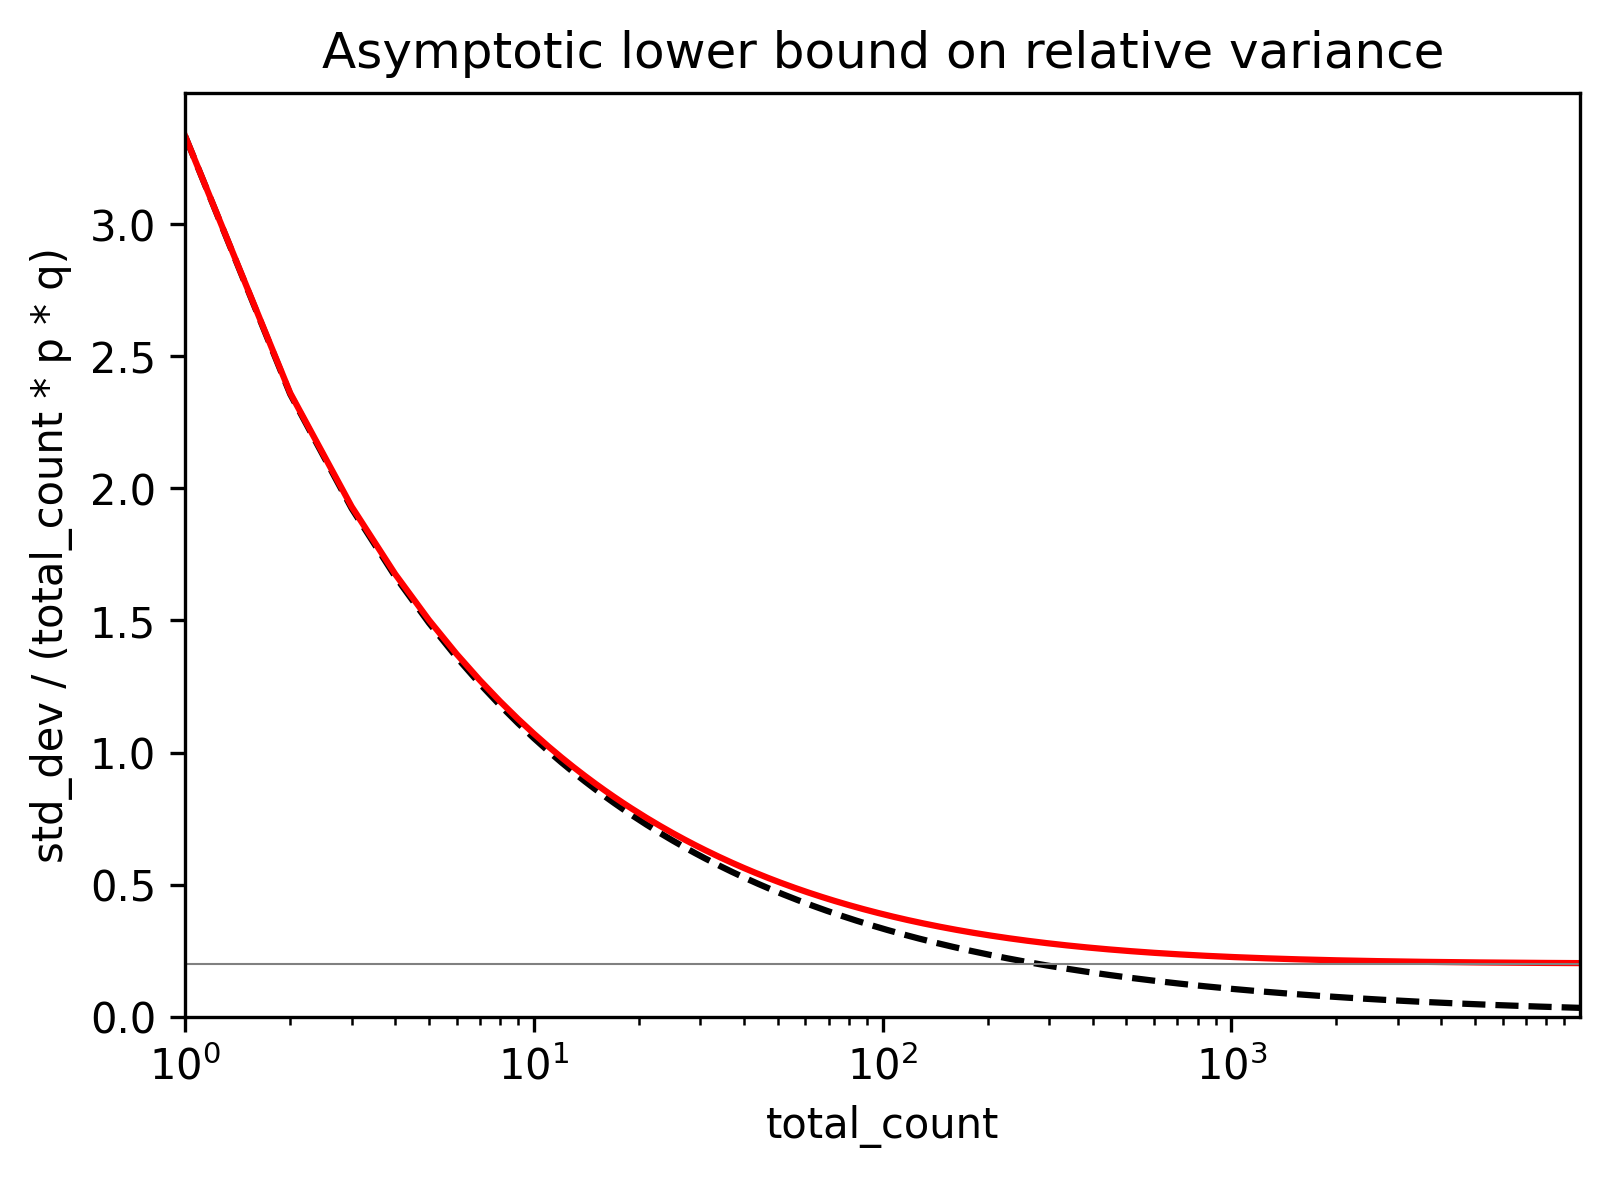

In [3]:
def plot_asymptote(o, p, ax=None):
    total_count = torch.arange(1, 10000.)
    q = 1 - p
    d1 = dist.Binomial(total_count, p)
    d2 = overdispersed_binomial(total_count, p, o)
    re1 = d1.variance.sqrt() / (total_count * p * q)
    re2 = d2.variance.sqrt() / (total_count * p * q)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(total_count, re1, 'k--')
    ax.plot(total_count, re2, 'r-')
    ax.axhline(o, color='0.5', lw=0.5)
    ax.set_xscale("log")
    ax.set_ylim(0, None)
    ax.set_xlim(1, total_count.max())

plt.figure(figsize=(6, 4), dpi=300).patch.set_color("white")
plot_asymptote(o=0.2, p=0.1)
plt.xlabel("total_count")
plt.ylabel("std_dev / (total_count * p * q)")
plt.title("Asymptotic lower bound on relative variance");

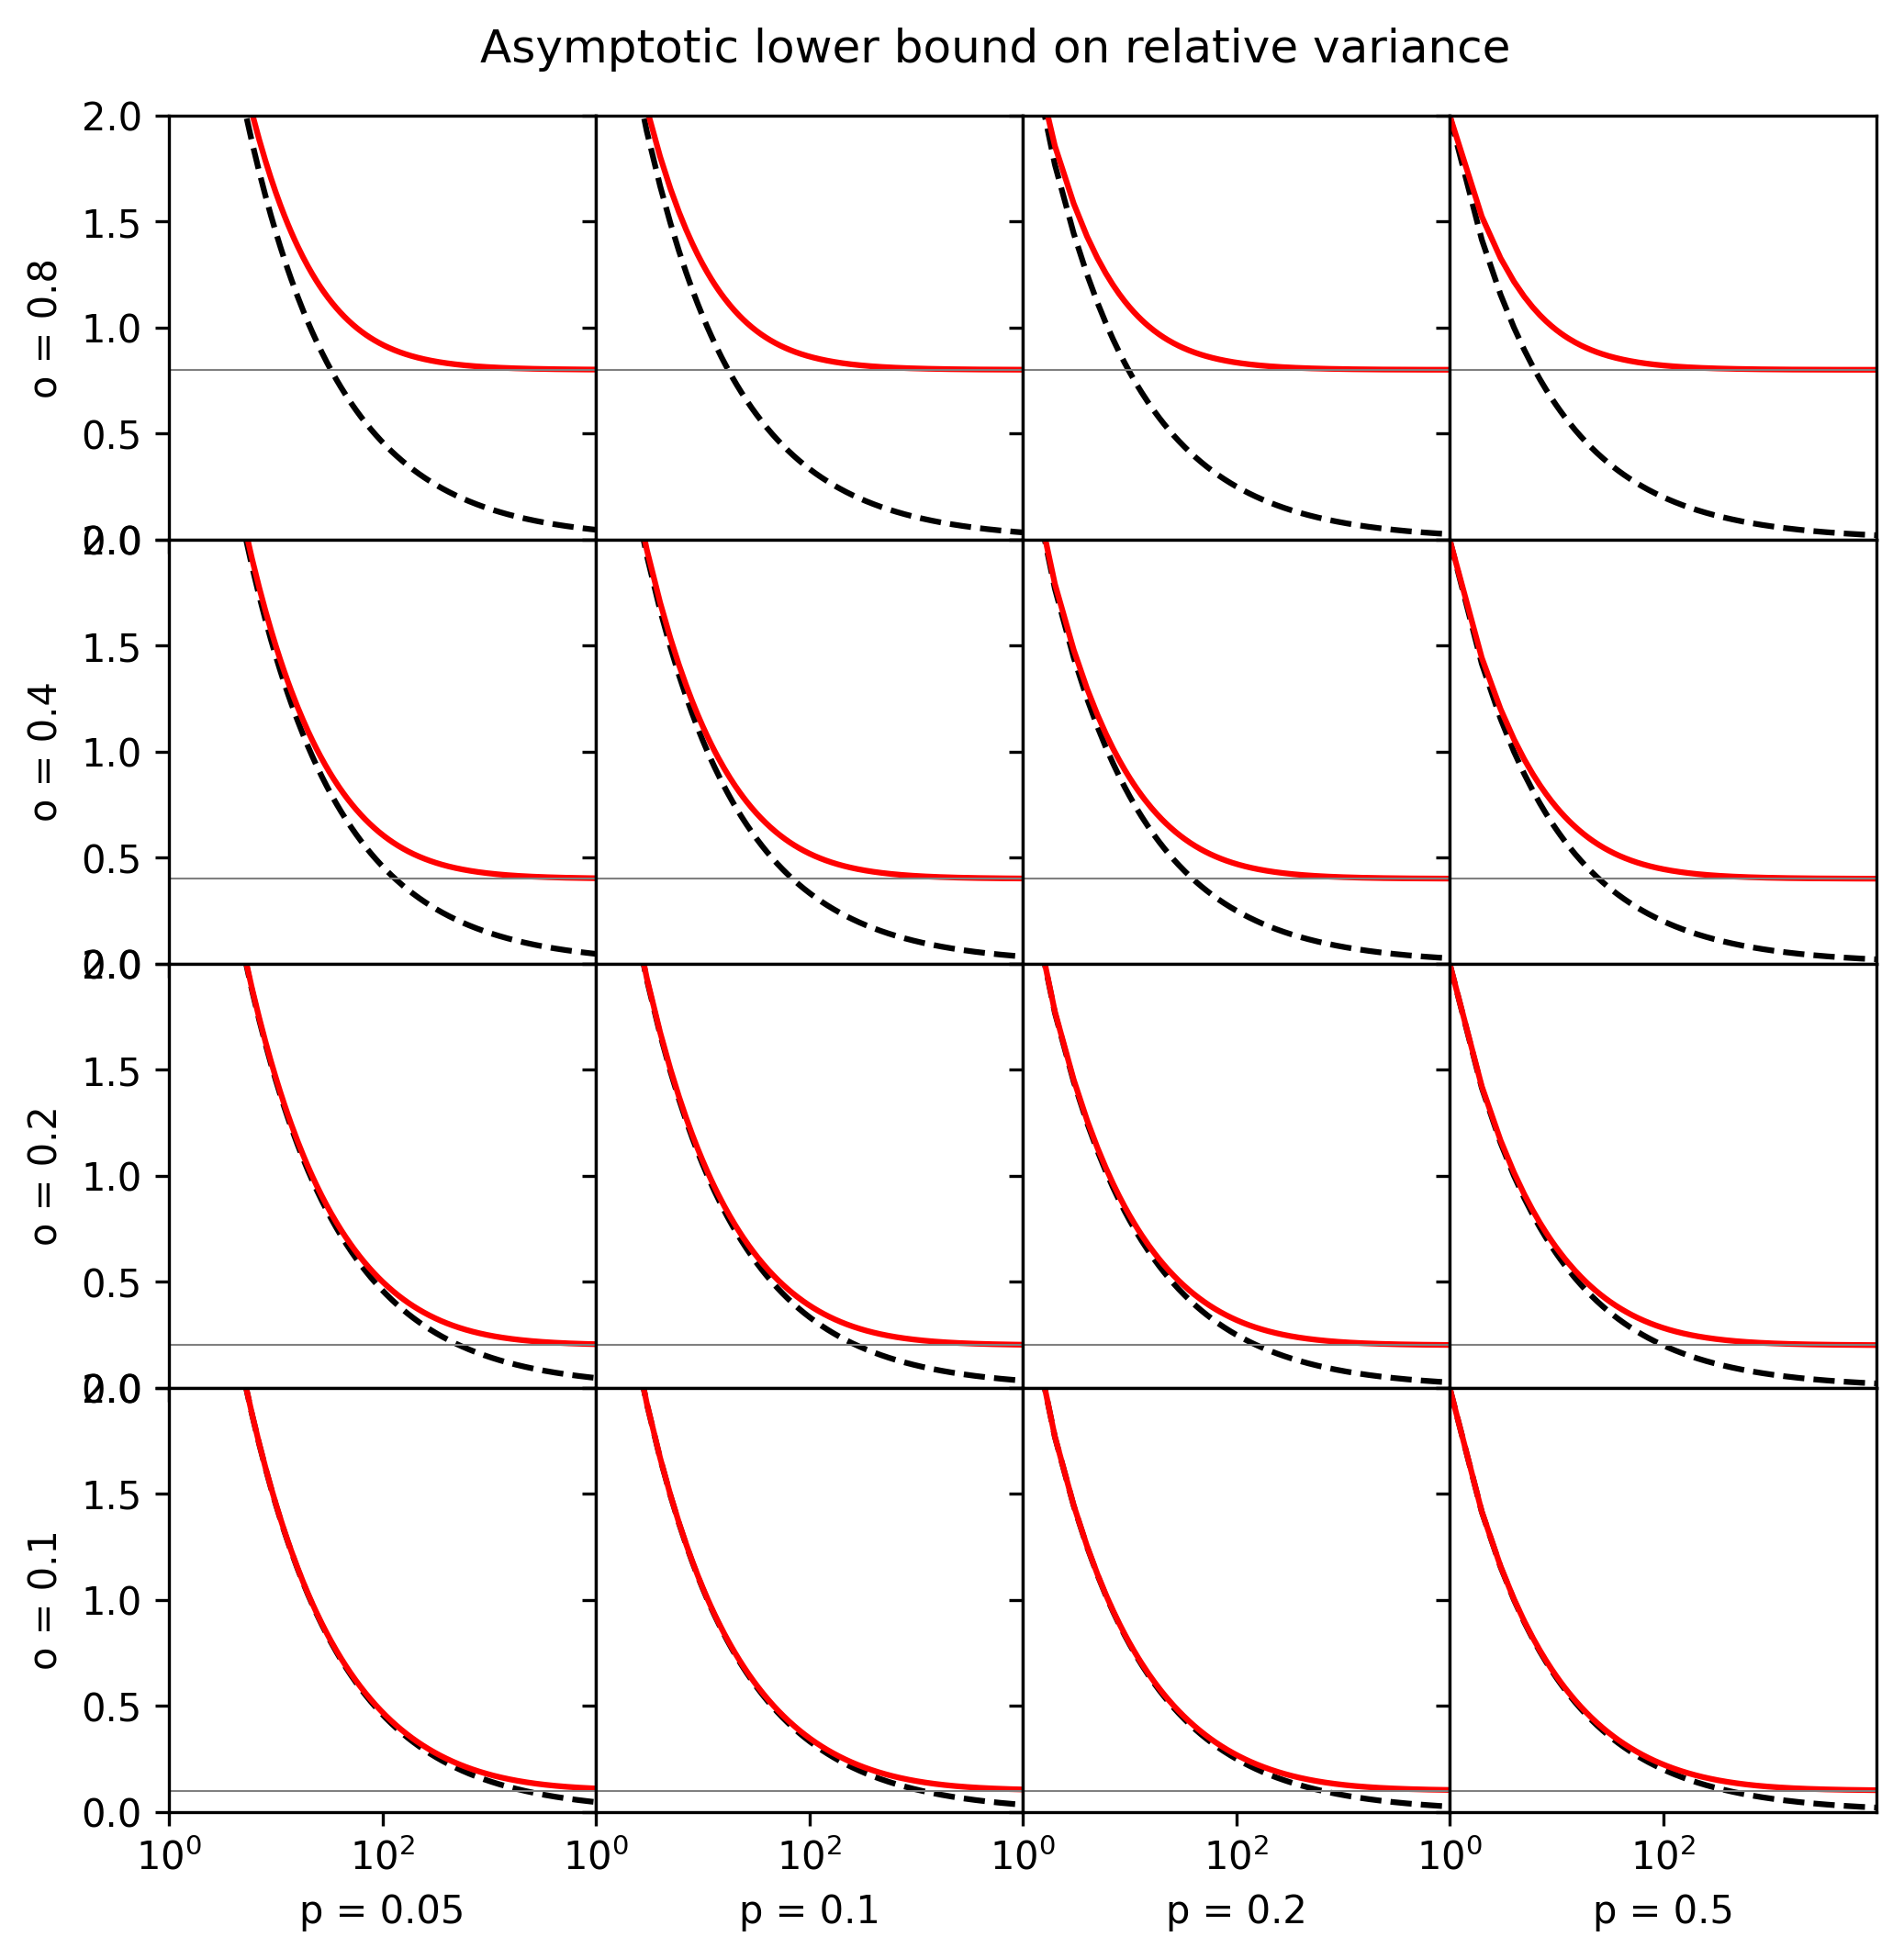

In [4]:
o_grid = [0.8, 0.4, 0.2, 0.1]
p_grid = [0.05, 0.1, 0.2, 0.5]
fig, axes = plt.subplots(len(o_grid), len(p_grid), figsize=(8,8),
                         sharex=True, sharey="row", dpi=300)
fig.patch.set_color("white")
for i, o in enumerate(o_grid):
    for j, p in enumerate(p_grid):
        ax = axes[i][j]
        plot_asymptote(o, p, ax)
        ax.set_ylim(0, 2)
        if i == len(o_grid) - 1:
            ax.set_xlabel("p = {}".format(p))
        if j == 0:
            ax.set_ylabel("o = {}".format(o))
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Asymptotic lower bound on relative variance", y=0.92);

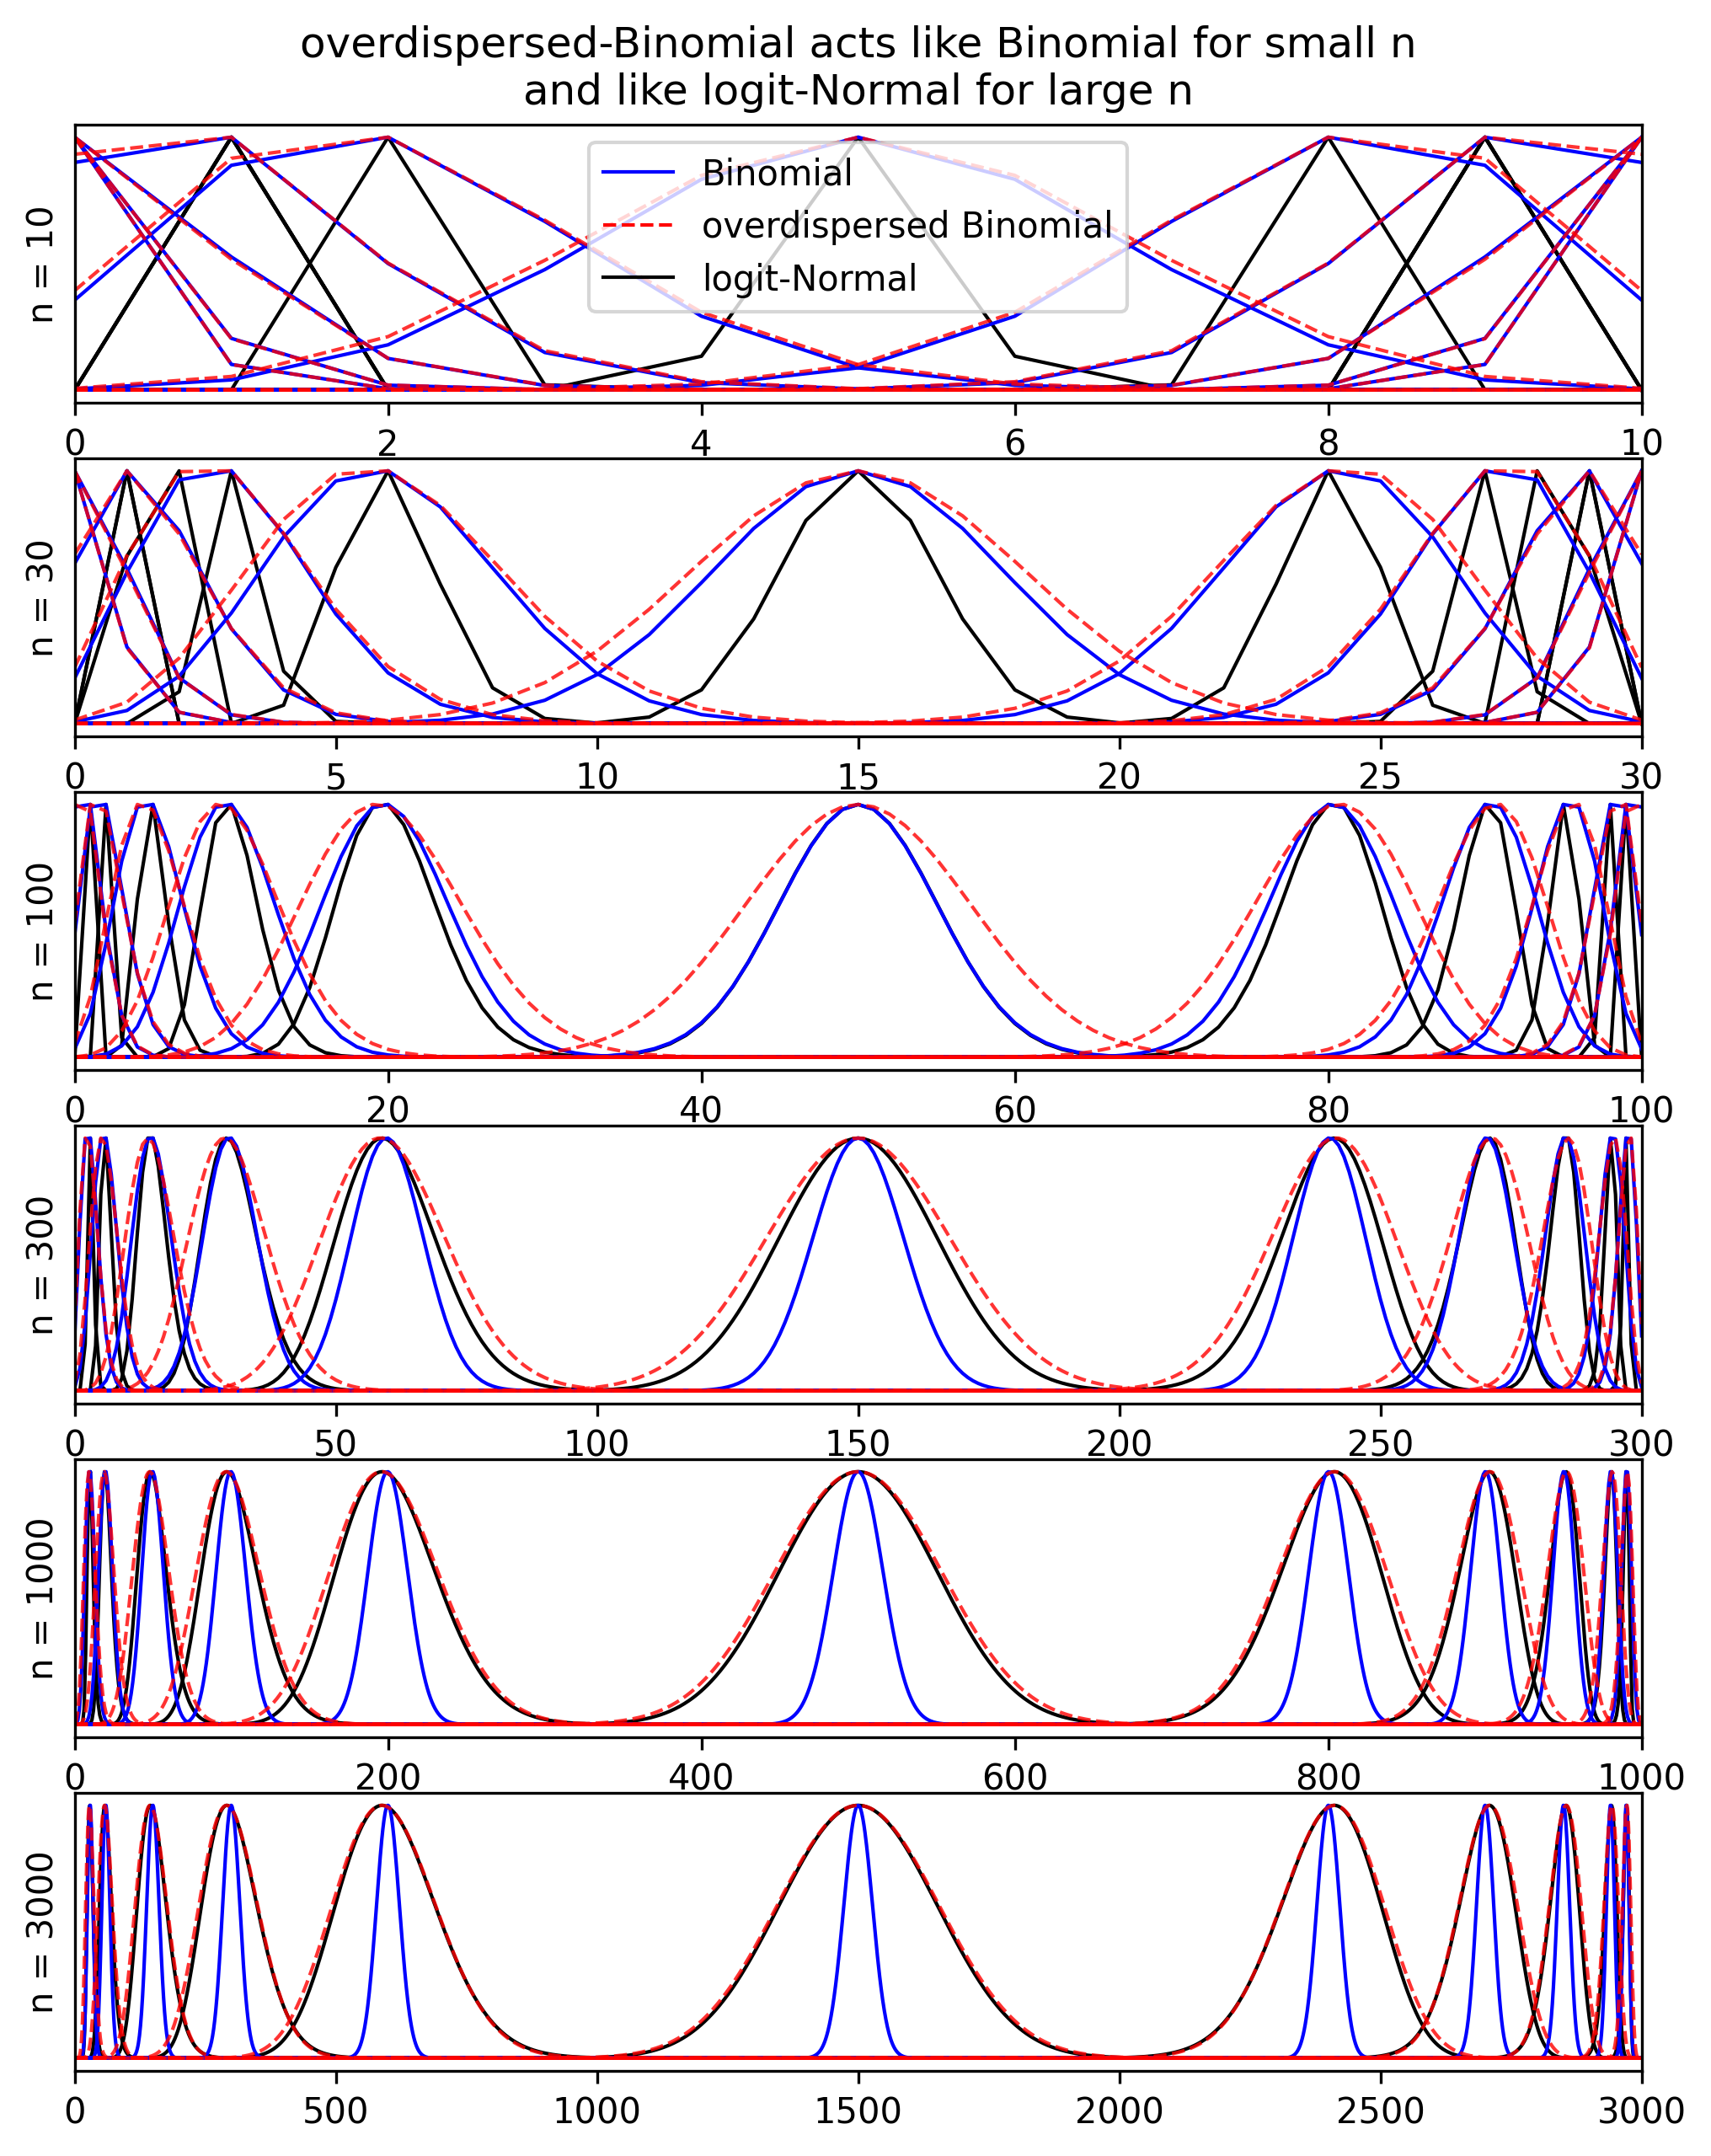

In [5]:
total_counts = [10, 30, 100, 300, 1000, 3000]
p = torch.tensor([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98, 0.99])
q = 1 - p
o = 0.2

fig, axes = plt.subplots(len(total_counts), figsize=(8, 10), dpi=300)
fig.patch.set_color("white")
for n, ax in zip(total_counts, axes):
    k = torch.arange(0., n + 1.).unsqueeze(-1)
    p1 = dist.Binomial(n, p).log_prob(k).exp()
    p2 = overdispersed_binomial(n, p, o).log_prob(k).exp()
    d3 = dist.TransformedDistribution(dist.Normal((p/(1-p)).log(), o), SigmoidTransform())
    p3 = d3.log_prob(k / n).exp() / n
    ax.plot(p3 / p3.max(0).values, "k-", lw=1)
    ax.plot(p1 / p1.max(0).values, "b-", lw=1)
    ax.plot(p2 / p2.max(0).values, "r--", lw=1, alpha=0.8)
    ax.set_xlim(0, n)
    ax.set_yticks(())
    ax.set_ylabel("n = {}".format(n))
axes[0].plot([], "b-", lw=1, label="Binomial")
axes[0].plot([], "r--", lw=1, label="overdispersed Binomial")
axes[0].plot([], "k-", lw=1, label="logit-Normal")
axes[0].legend(loc="upper center")
axes[0].set_title("overdispersed-Binomial acts like Binomial for small n\n"
                  "and like logit-Normal for large n");

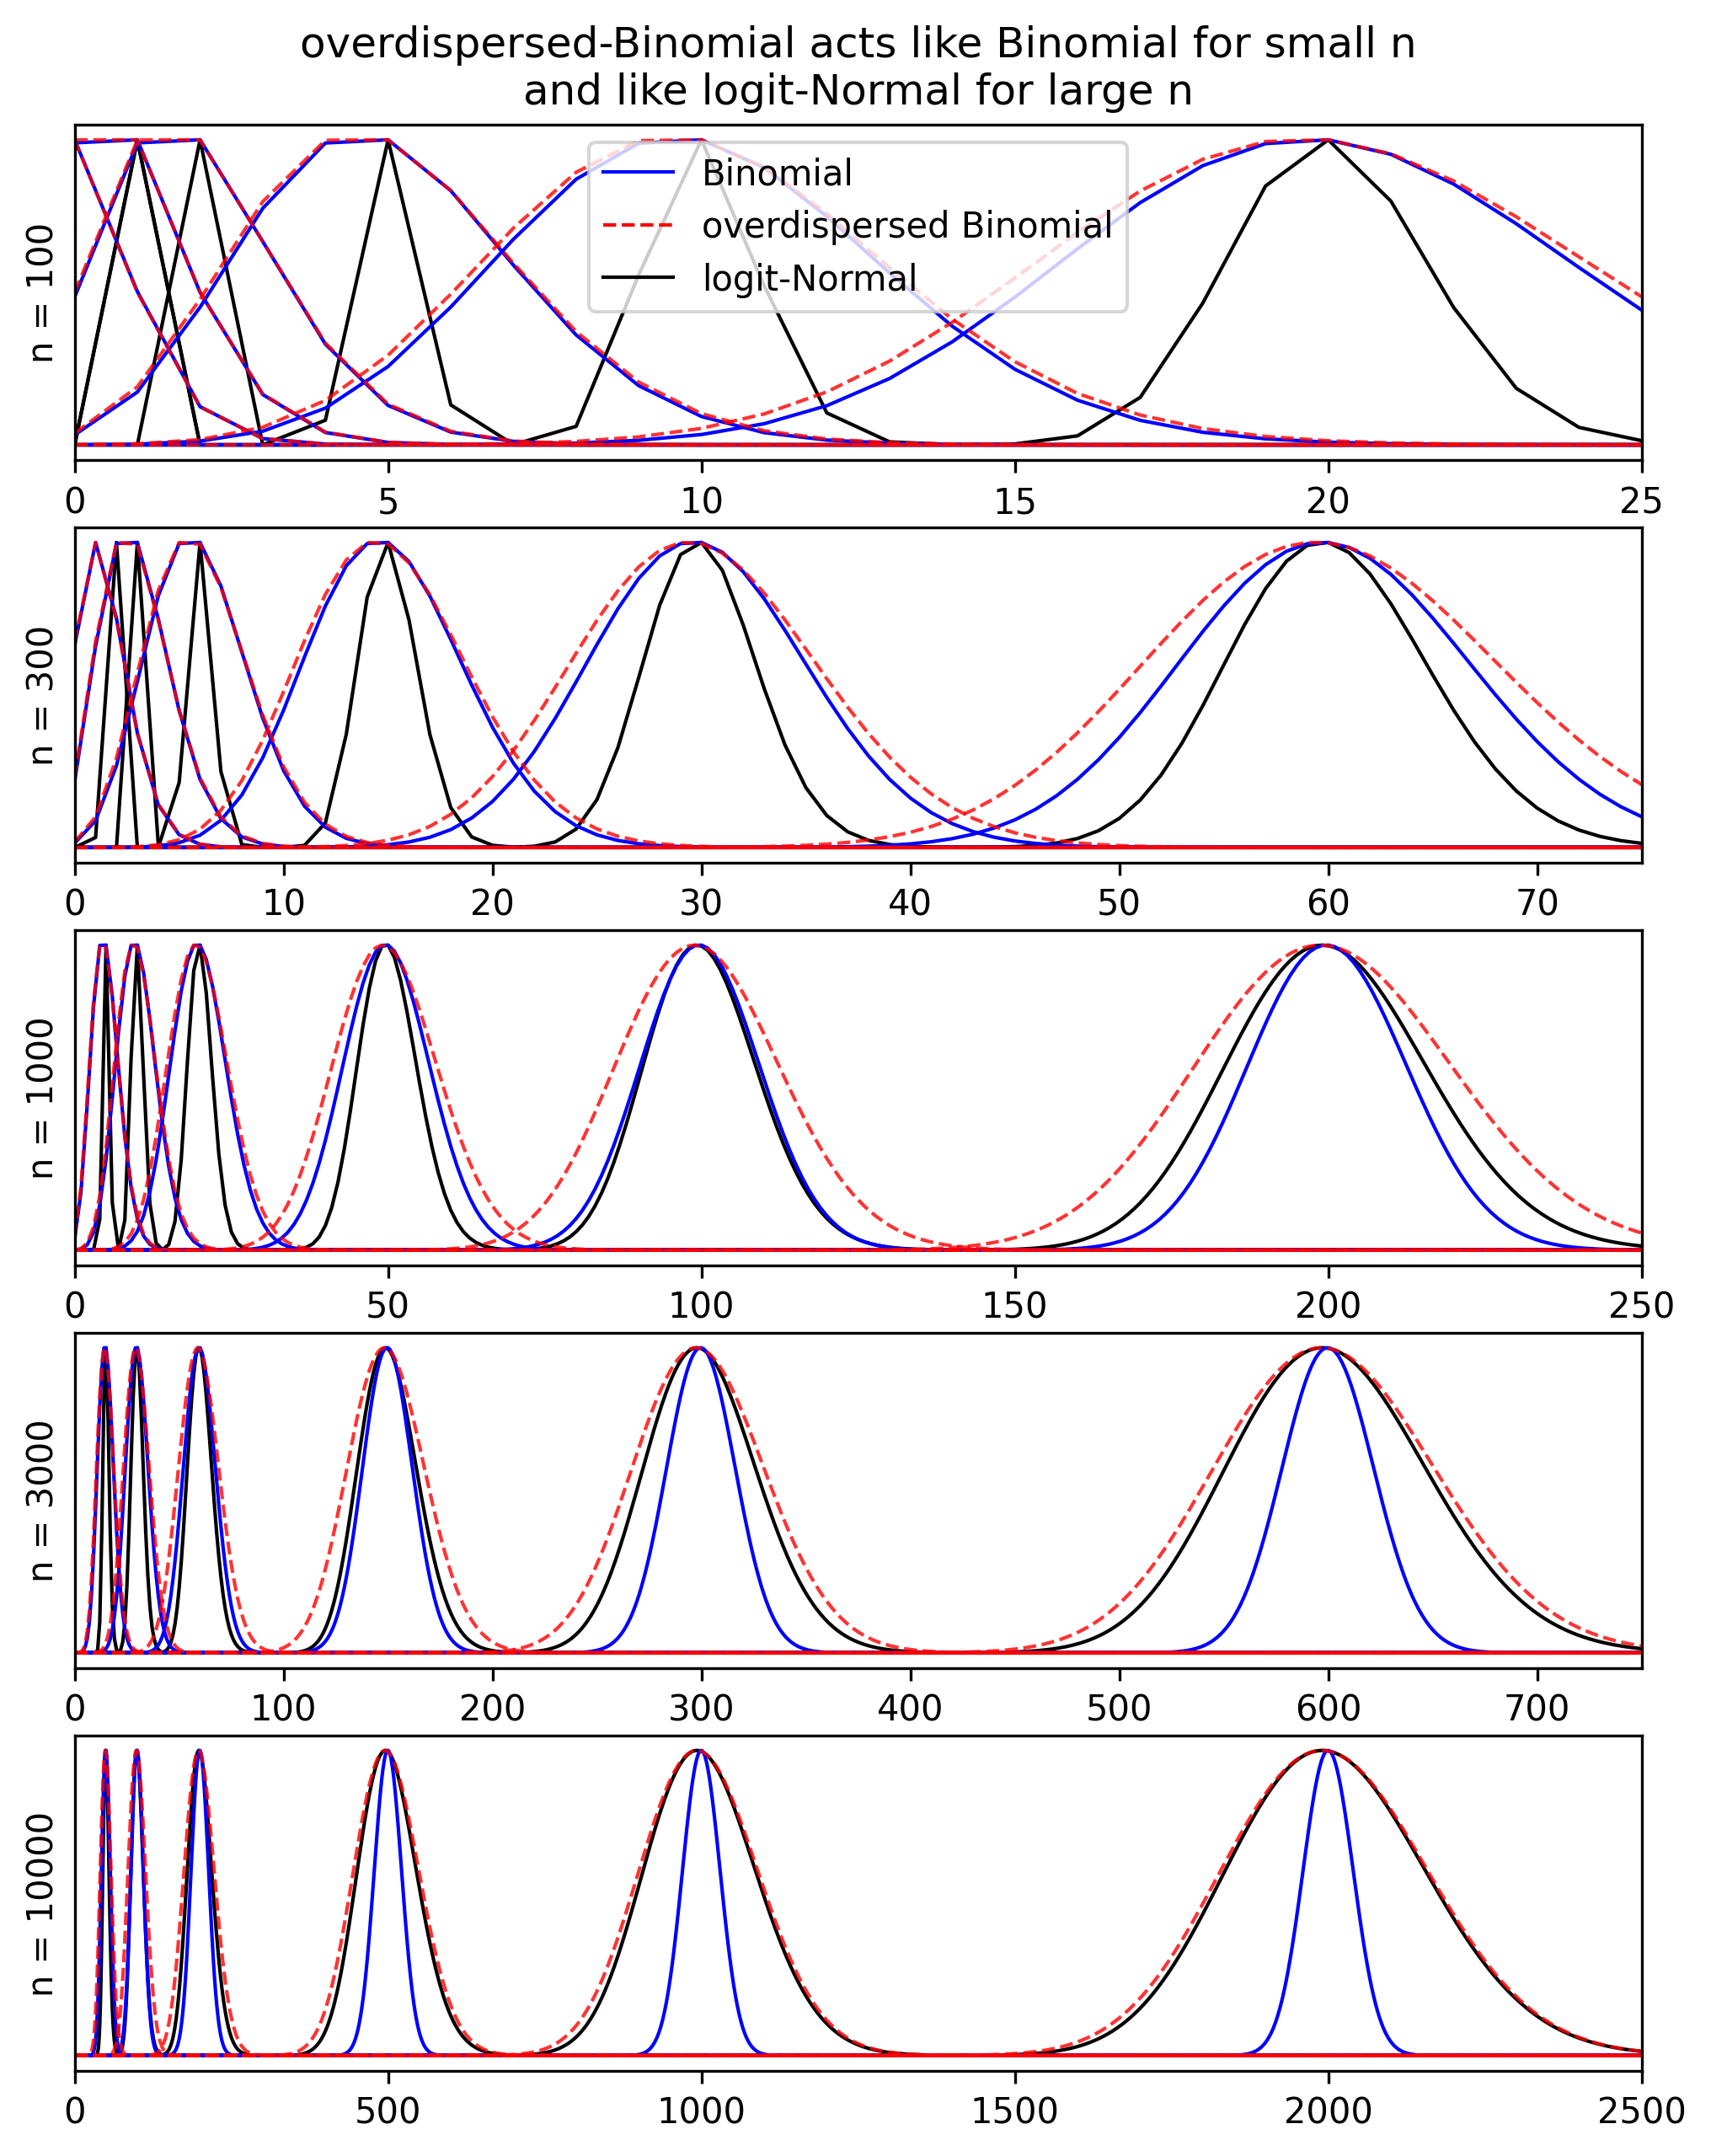

In [6]:
total_counts = [100, 300, 1000, 3000, 10000]
p = torch.tensor([0.005, 0.01, 0.02, 0.05, 0.1, 0.2])
q = 1 - p
o = 0.1

fig, axes = plt.subplots(len(total_counts), figsize=(8, 10), dpi=300)
fig.patch.set_color("white")
for n, ax in zip(total_counts, axes):
    k = torch.arange(0., n // 4 + 1.).unsqueeze(-1)
    p1 = dist.Binomial(n, p).log_prob(k).exp()
    p2 = overdispersed_binomial(n, p, o).log_prob(k).exp()
    d3 = dist.TransformedDistribution(dist.Normal((p/(1-p)).log(), o), SigmoidTransform())
    p3 = d3.log_prob(k / n).exp() / n
    ax.plot(p3 / p3.max(0).values, "k-", lw=1)
    ax.plot(p1 / p1.max(0).values, "b-", lw=1)
    ax.plot(p2 / p2.max(0).values, "r--", lw=1, alpha=0.8)
    ax.set_xlim(0, n / 4)
    ax.set_yticks(())
    ax.set_ylabel("n = {}".format(n))
axes[0].plot([], "b-", lw=1, label="Binomial")
axes[0].plot([], "r--", lw=1, label="overdispersed Binomial")
axes[0].plot([], "k-", lw=1, label="logit-Normal")
axes[0].legend(loc="upper center")
axes[0].set_title("overdispersed-Binomial acts like Binomial for small n\n"
                  "and like logit-Normal for large n");

## Testing the implementation

In [7]:
from pyro.contrib.epidemiology import binomial_dist

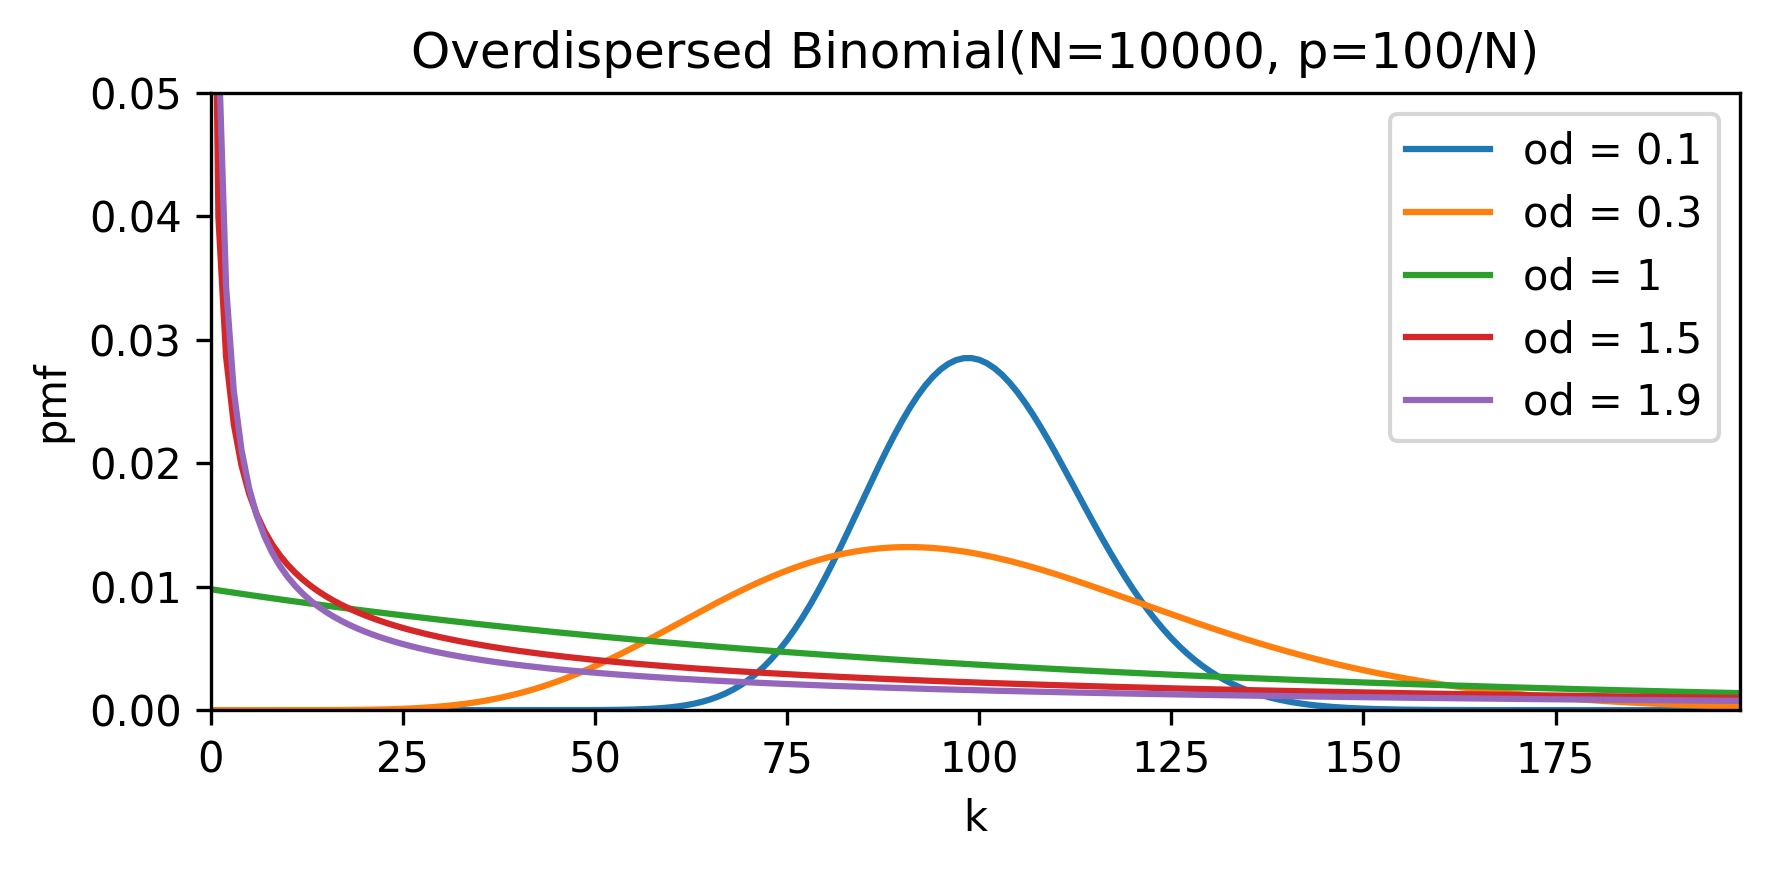

In [8]:
N = 10000.
p = 100. / N
k = torch.arange(200.)
plt.figure(figsize=(6, 3), dpi=300)
for od in [0.1, 0.3, 1.0, 1.5, 1.9]:
    d = binomial_dist(N, p, overdispersion=od)
    plt.plot(k, d.log_prob(k).exp(), label=f"od = {od:0.2g}")
plt.legend(loc="best")
plt.title(f"Overdispersed Binomial(N={int(N)}, p=100/N)")
plt.xlabel("k")
plt.xlim(0, k.max().item())
plt.ylim(0, 0.05)
plt.ylabel("pmf")
plt.tight_layout()

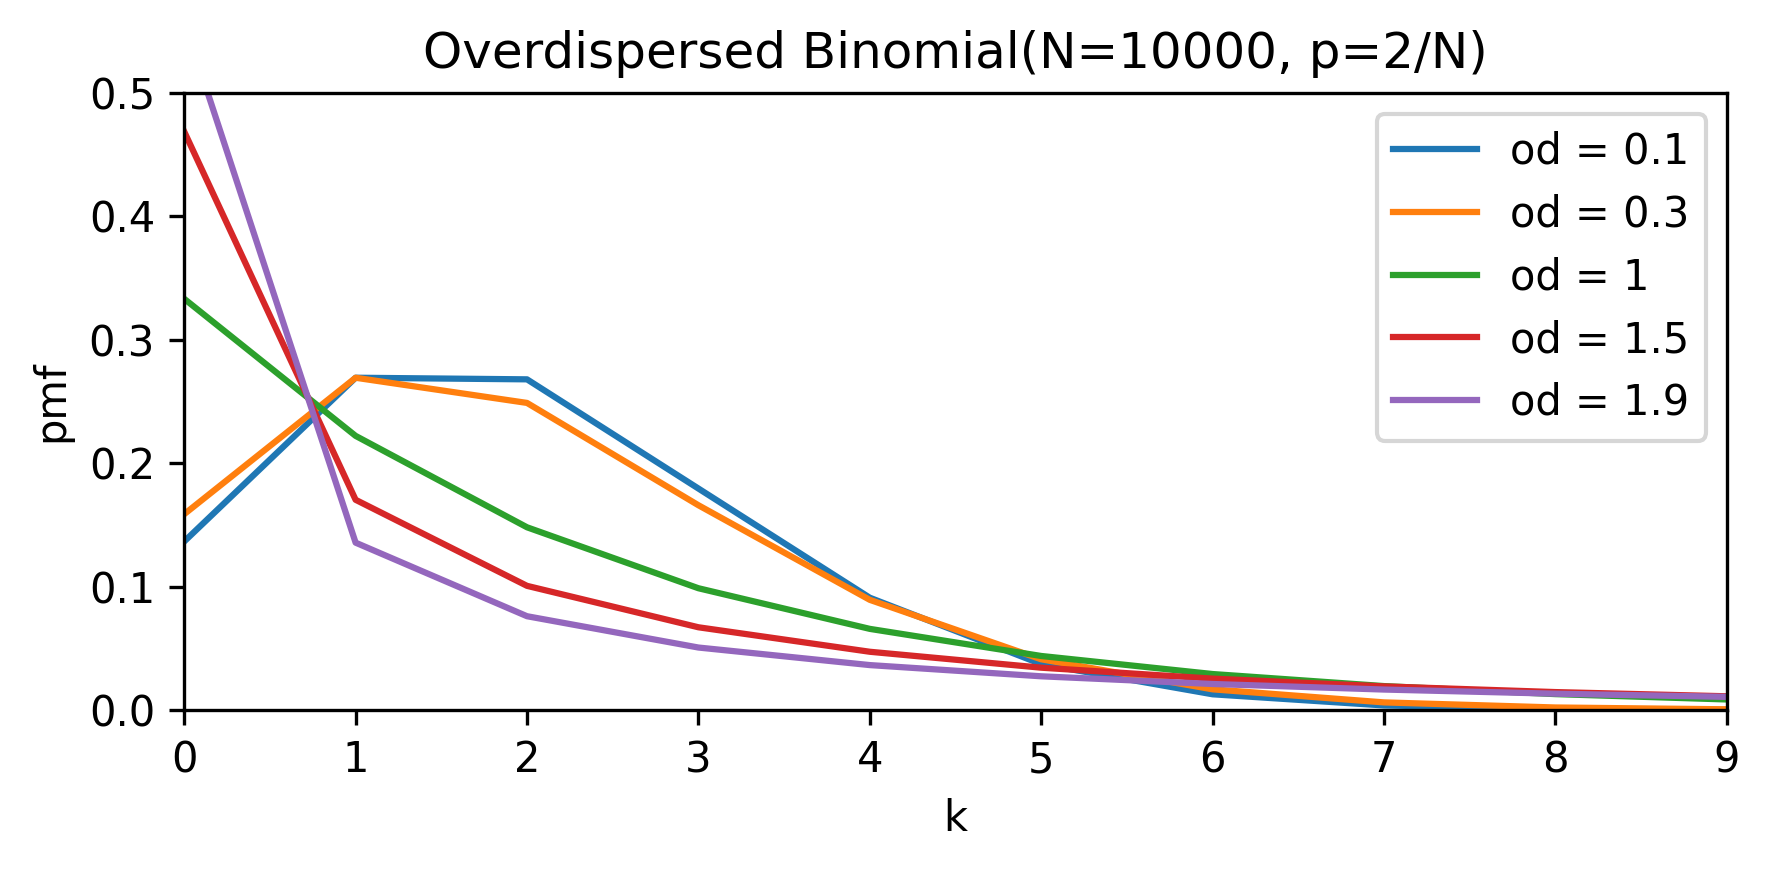

In [9]:
N = 10000.
p = 2. / N
k = torch.arange(10.)
plt.figure(figsize=(6, 3), dpi=300)
for od in [0.1, 0.3, 1.0, 1.5, 1.9]:
    d = binomial_dist(N, p, overdispersion=od)
    plt.plot(k, d.log_prob(k).exp(), label=f"od = {od:0.2g}")
plt.legend(loc="best")
plt.title(f"Overdispersed Binomial(N={int(N)}, p=2/N)")
plt.xlabel("k")
plt.xlim(0, k.max().item())
plt.ylim(0, 0.5)
plt.ylabel("pmf")
plt.tight_layout()

## Relaxations

We'd like to relax the bounded integer distribution `binomial_dist()` to a continuous distribution with support the entire real line. Consider a few possibilities.

First consider relaxing to a moment-matched Normal distribution.

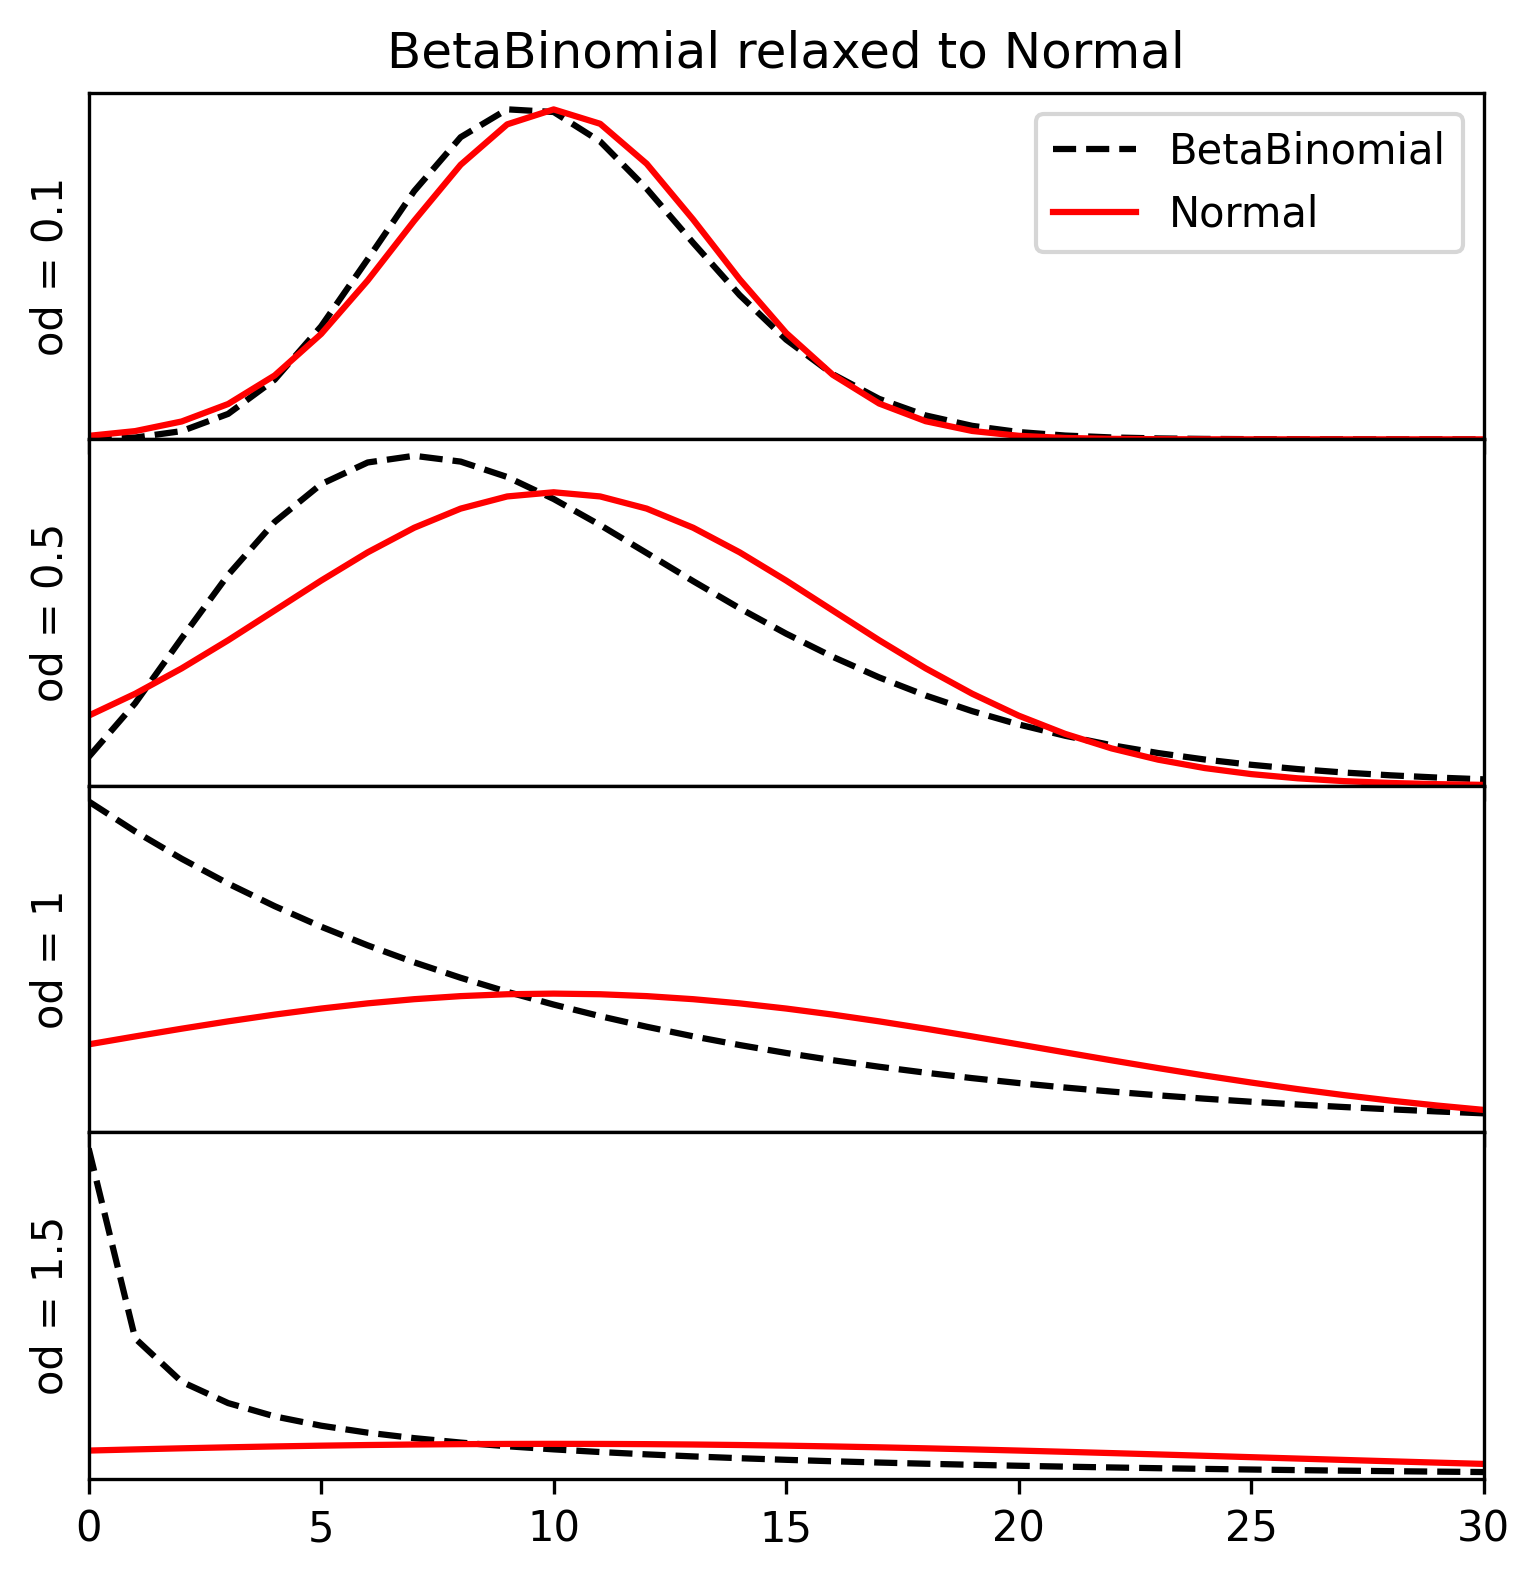

In [10]:
N = 10000.
p = 10. / N
k = torch.arange(31.)
ods = [0.1, 0.5, 1.0, 1.5]
fig, axes = plt.subplots(len(ods), sharex=True, figsize=(6, 6), dpi=300)
for od, ax in zip(ods, axes):
    d = binomial_dist(N, p, overdispersion=od)
    ax.plot(k, d.log_prob(k).exp(), "k--", label="BetaBinomial")
    d1 = dist.Normal(d.mean, d.variance.sqrt())
    ax.plot(k, d1.log_prob(k).exp(), "r-", label="Normal")
    ax.set_yticks(())
    ax.set_ylim(0, None)
    ax.set_ylabel(f"od = {od:0.2g}")
axes[0].set_title("BetaBinomial relaxed to Normal")
axes[0].legend(loc="best")
axes[-1].set_xlim(0, 30)
plt.subplots_adjust(hspace=0)

Next consider a moment-matched Beta distribution. Note this has bounded support, but is a better fit.

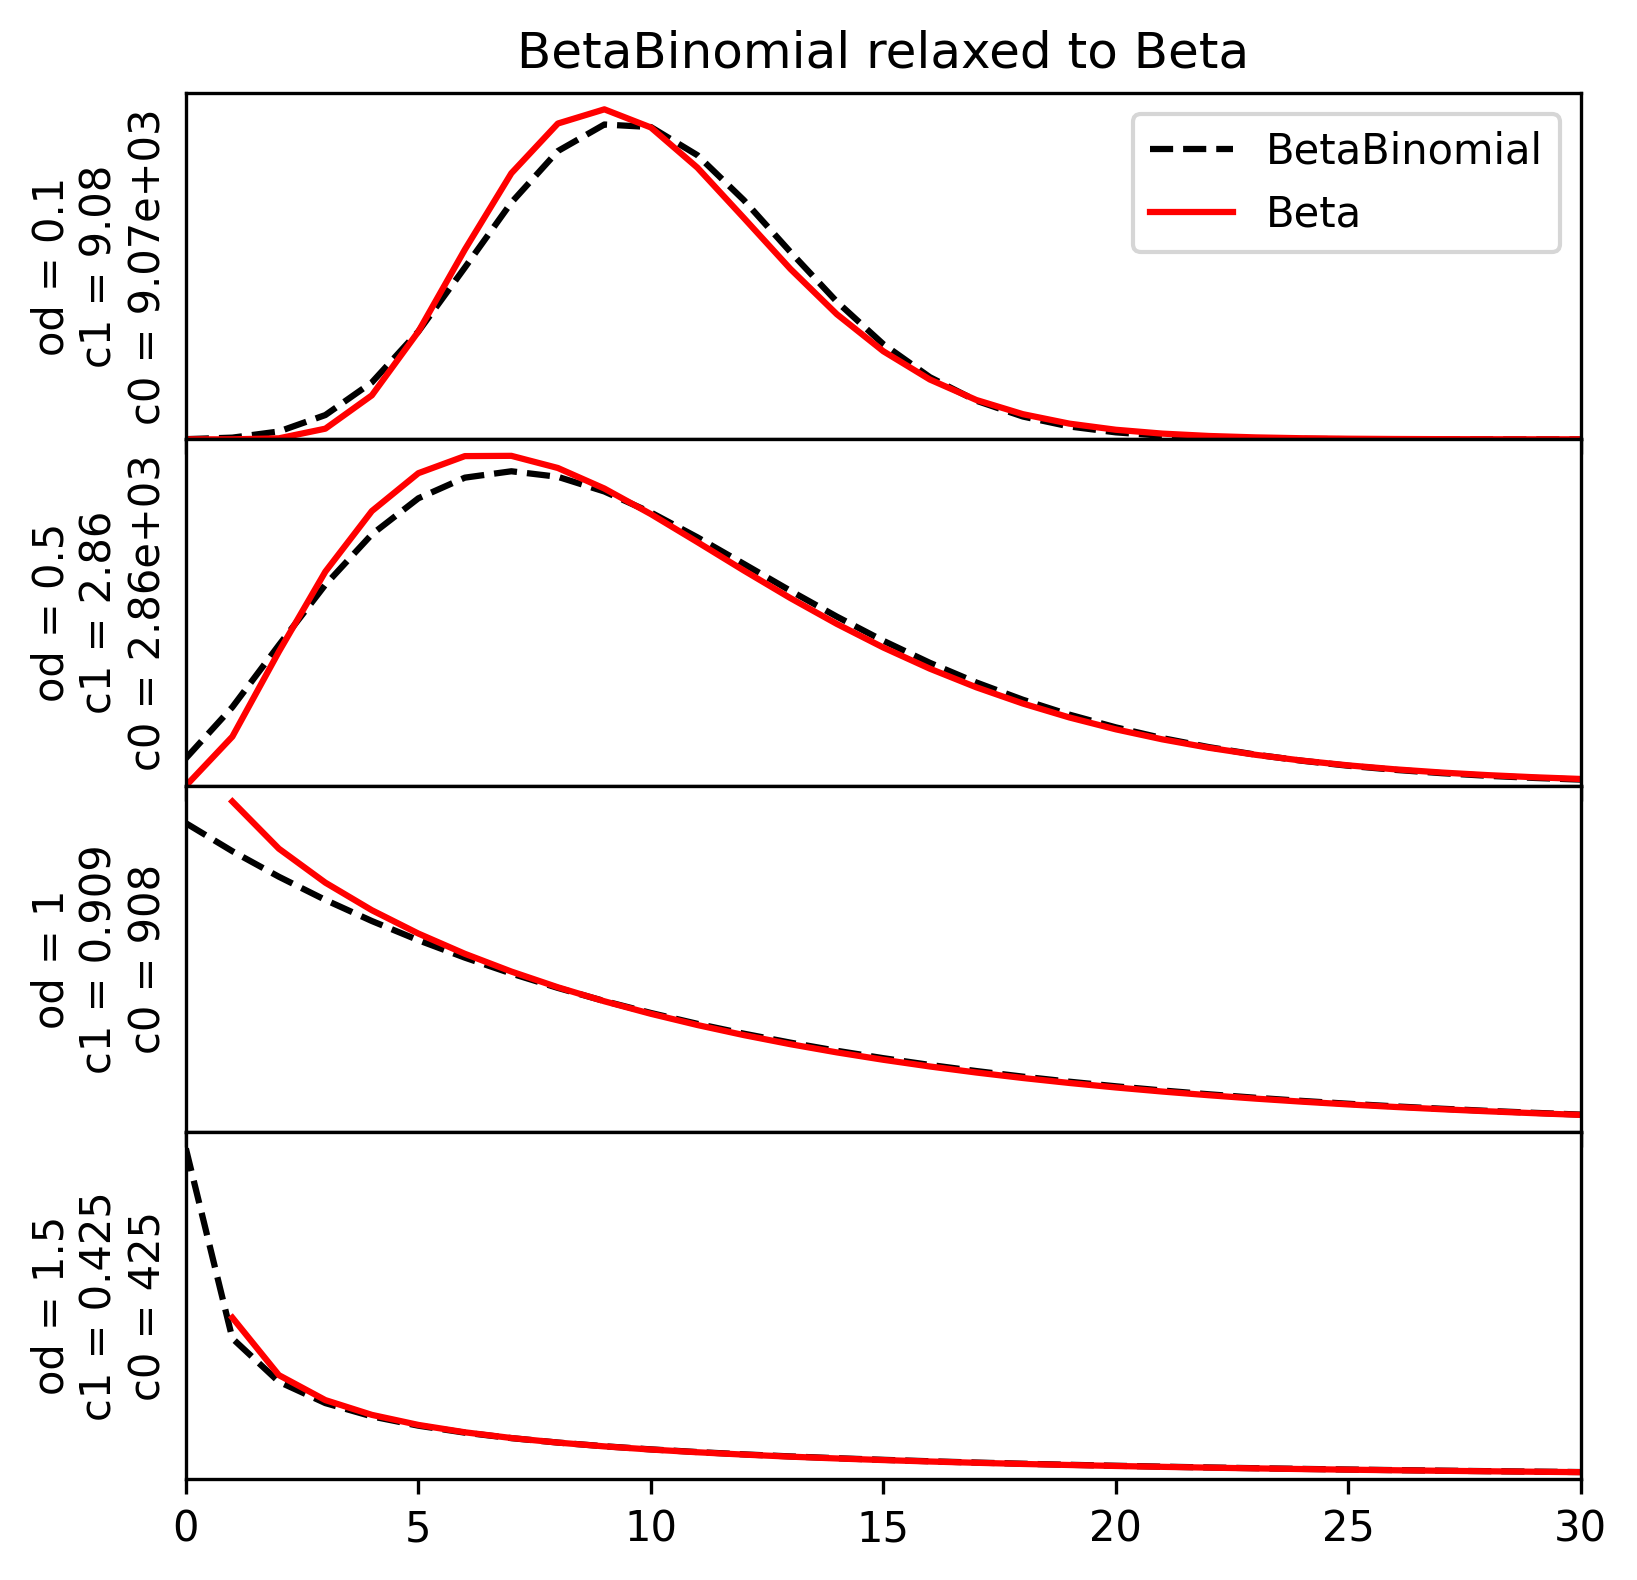

In [11]:
N = 10000.
p = 10. / N
k = torch.arange(31.)
ods = [0.1, 0.5, 1.0, 1.5]
fig, axes = plt.subplots(len(ods), sharex=True, figsize=(6, 6), dpi=300)
for od, ax in zip(ods, axes):
    d = binomial_dist(N, p, overdispersion=od)
    ax.plot(k, d.log_prob(k).exp(), "k--", label="BetaBinomial")
    q = 1 - p
    c = p * q / (d.variance / N**2) - 1
    c1 = p * c
    c0 = q * c
    d1 = dist.TransformedDistribution(
        dist.Beta(c1, c0),
        dist.transforms.AffineTransform(0, N)
    )
    ax.plot(k, d1.log_prob(k).exp(), "r-", label="Beta")
    ax.set_yticks(())
    ax.set_ylim(0, None)
    ax.set_ylabel(f"od = {od:0.2g}\nc1 = {c1:0.3g}\nc0 = {c0:0.3g}")
axes[0].set_title("BetaBinomial relaxed to Beta")
axes[0].legend(loc="best")
axes[-1].set_xlim(0, 30)
plt.subplots_adjust(hspace=0)

By mixing the Beta and Normal we can achieve both good fit and unbounded support.

In [12]:
def plot_approx(N, N_times_p, lb, ub):
    p = N_times_p / N
    k = torch.linspace(lb, ub, 400)
    ods = [0.1, 0.3, 0.8, 1.0]
    fig, axes = plt.subplots(len(ods), sharex=True, figsize=(6, 6), dpi=300)
    for od, ax in zip(ods, axes):
        d = binomial_dist(N, p, overdispersion=od)
        ax.plot(k, d.log_prob(k).exp(), "k--", label="BetaBinomial")
        
        # Plot the simple normal approximation.
        mean = d.mean
        variance = d.variance + 1/12  # add variance of dequantization
        d1 = dist.Normal(mean, variance.sqrt())
        p1 = d1.log_prob(k).exp()
        ax.plot(k, p1, "b-", lw=1, label="Normal")
        
        # For likelihoods we require finite values so we lower bound concentration by 1.
        # For priors we require finite gradients so we lower bound by 2.
        # In the implementation, the decision is made based on k.requires_grad.
        for bound, color in zip([2, 1], ["green", "red"]):
            # Moment-match a Beta, but ensure its concentration is not too low.
            pp = (mean + 1 / 2) / (N + 1)
            q = 1 - pp
            c = pp * q / (variance / (N + 1)**2) - 1
            c = c.clamp(min=bound / min(pp, q))
            c1 = pp * c
            c0 = q * c
            d2 = dist.TransformedDistribution(
                dist.Beta(c1, c0),
                dist.transforms.AffineTransform(-1 / 2, N + 1)
            )
            p2 = torch.where((-1 / 2 < k) & (k < N + 1 / 2),
                             d2.log_prob(k).exp(),
                             torch.tensor(0.))
    
            # Construct an ad-hoc weighted mixture of a Beta and a Normal.
            # The two distributions will have identical means and variances,
            # except the Beta's variance may be clamped above a lower bound.
            w1 = 0.1
            w2 = 0.9
            w1, w2 = w1/(w1 + w2), w2/(w1 + w2)
            ax.plot(k, p1 * w1 + p2 * w2, color=color, lw=bound,
                    label=f"Normal+Beta ({bound})")

        ax.set_yticks(())
        ax.axvline(0, color="gray", lw=0.5)
        ax.axvline(N, color="gray", lw=0.5)
        ax.set_ylim(0, None)
        ax.set_ylabel(f"od = {od:0.2g}\nc1 = {c1:0.1f}\nc0 = {c0:0.1f}")
    axes[0].set_title("BetaBinomial relaxed to Beta+Normal")
    axes[0].legend(loc="best")
    axes[-1].set_xlim(lb, ub)
    plt.subplots_adjust(hspace=0)

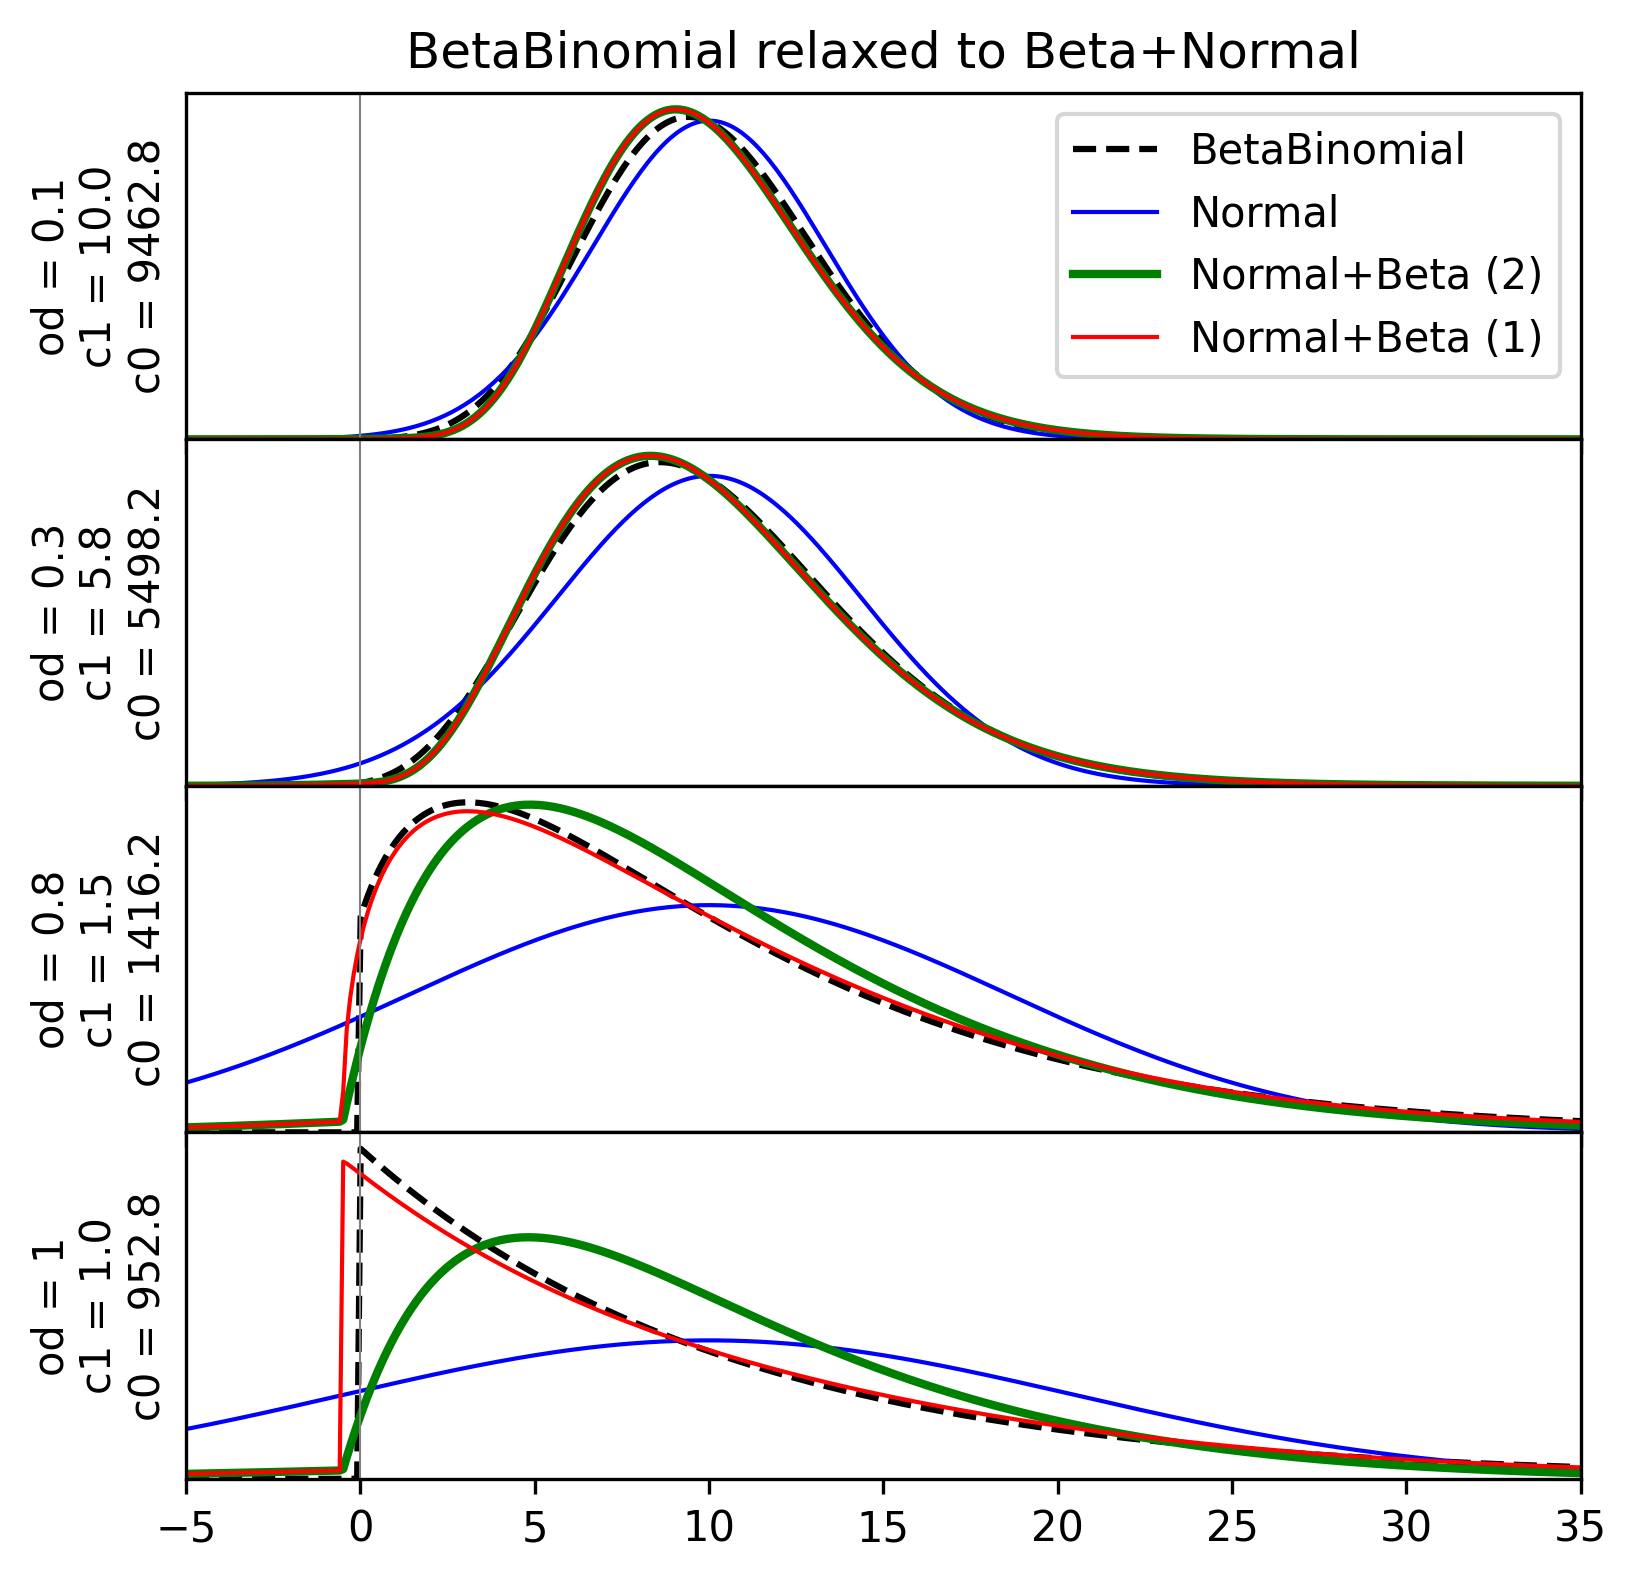

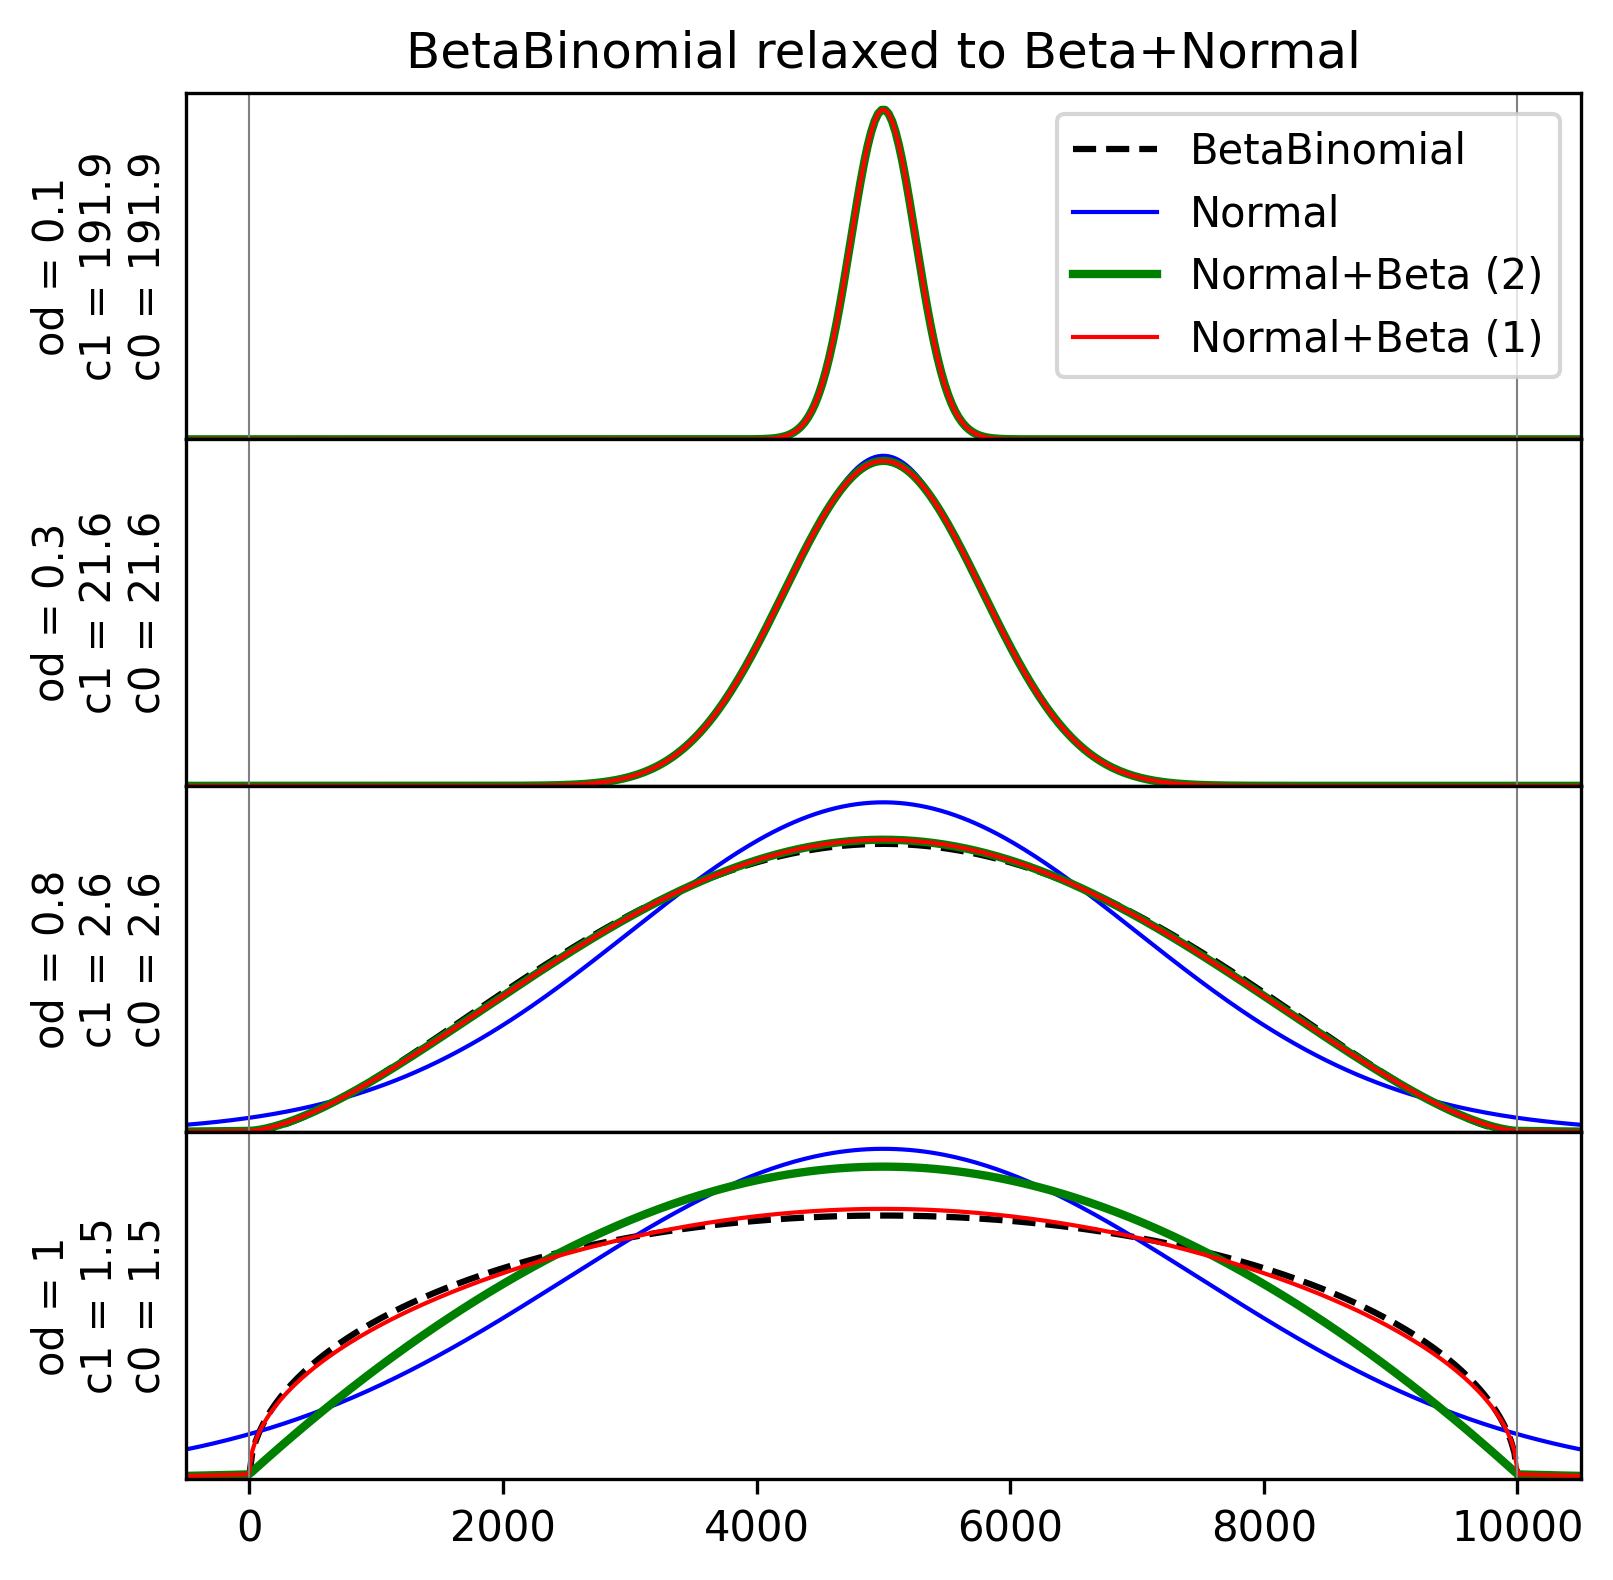

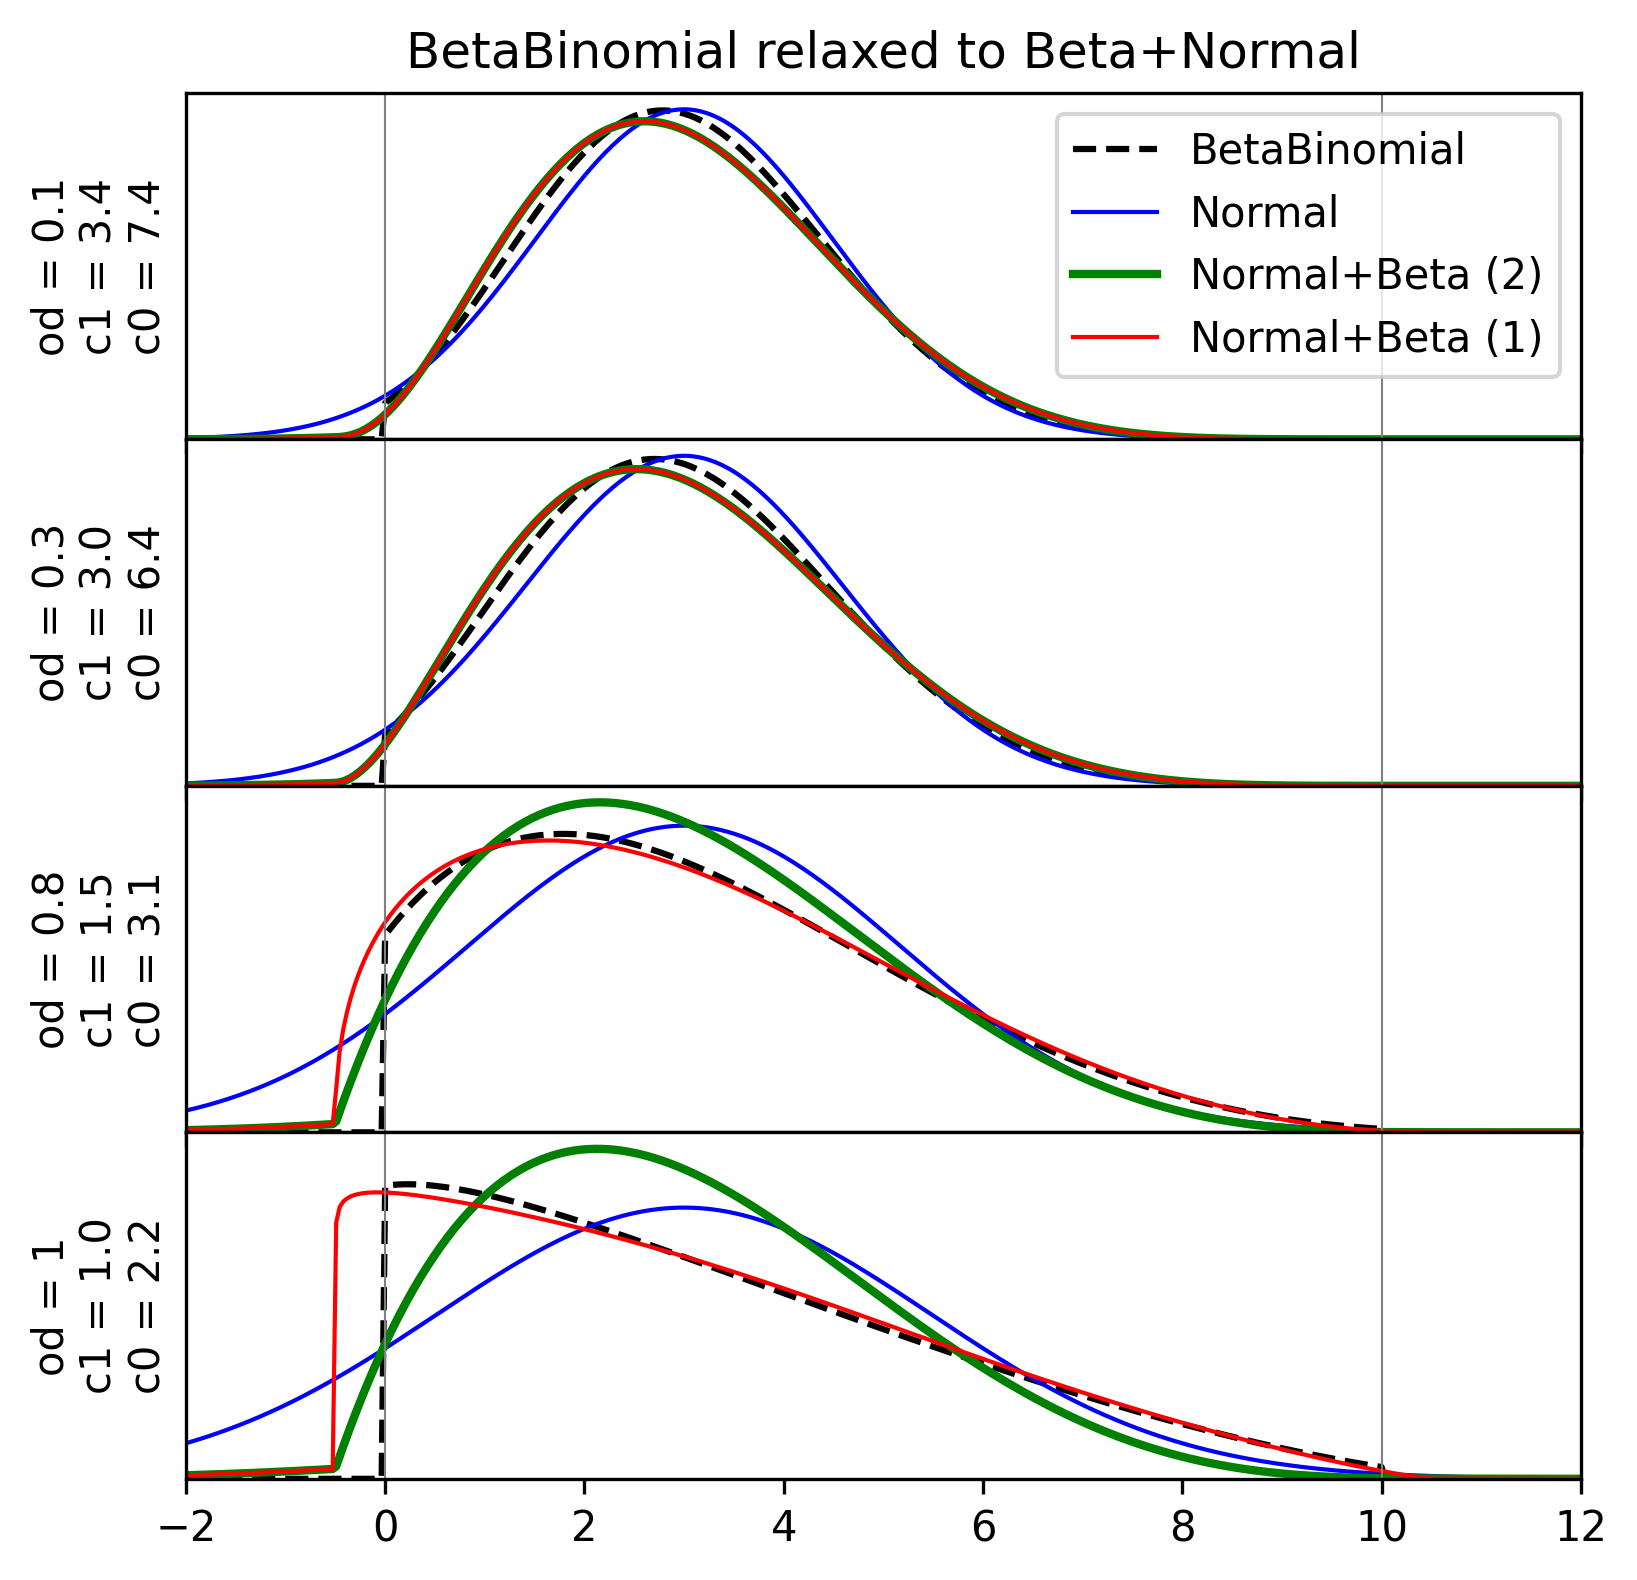

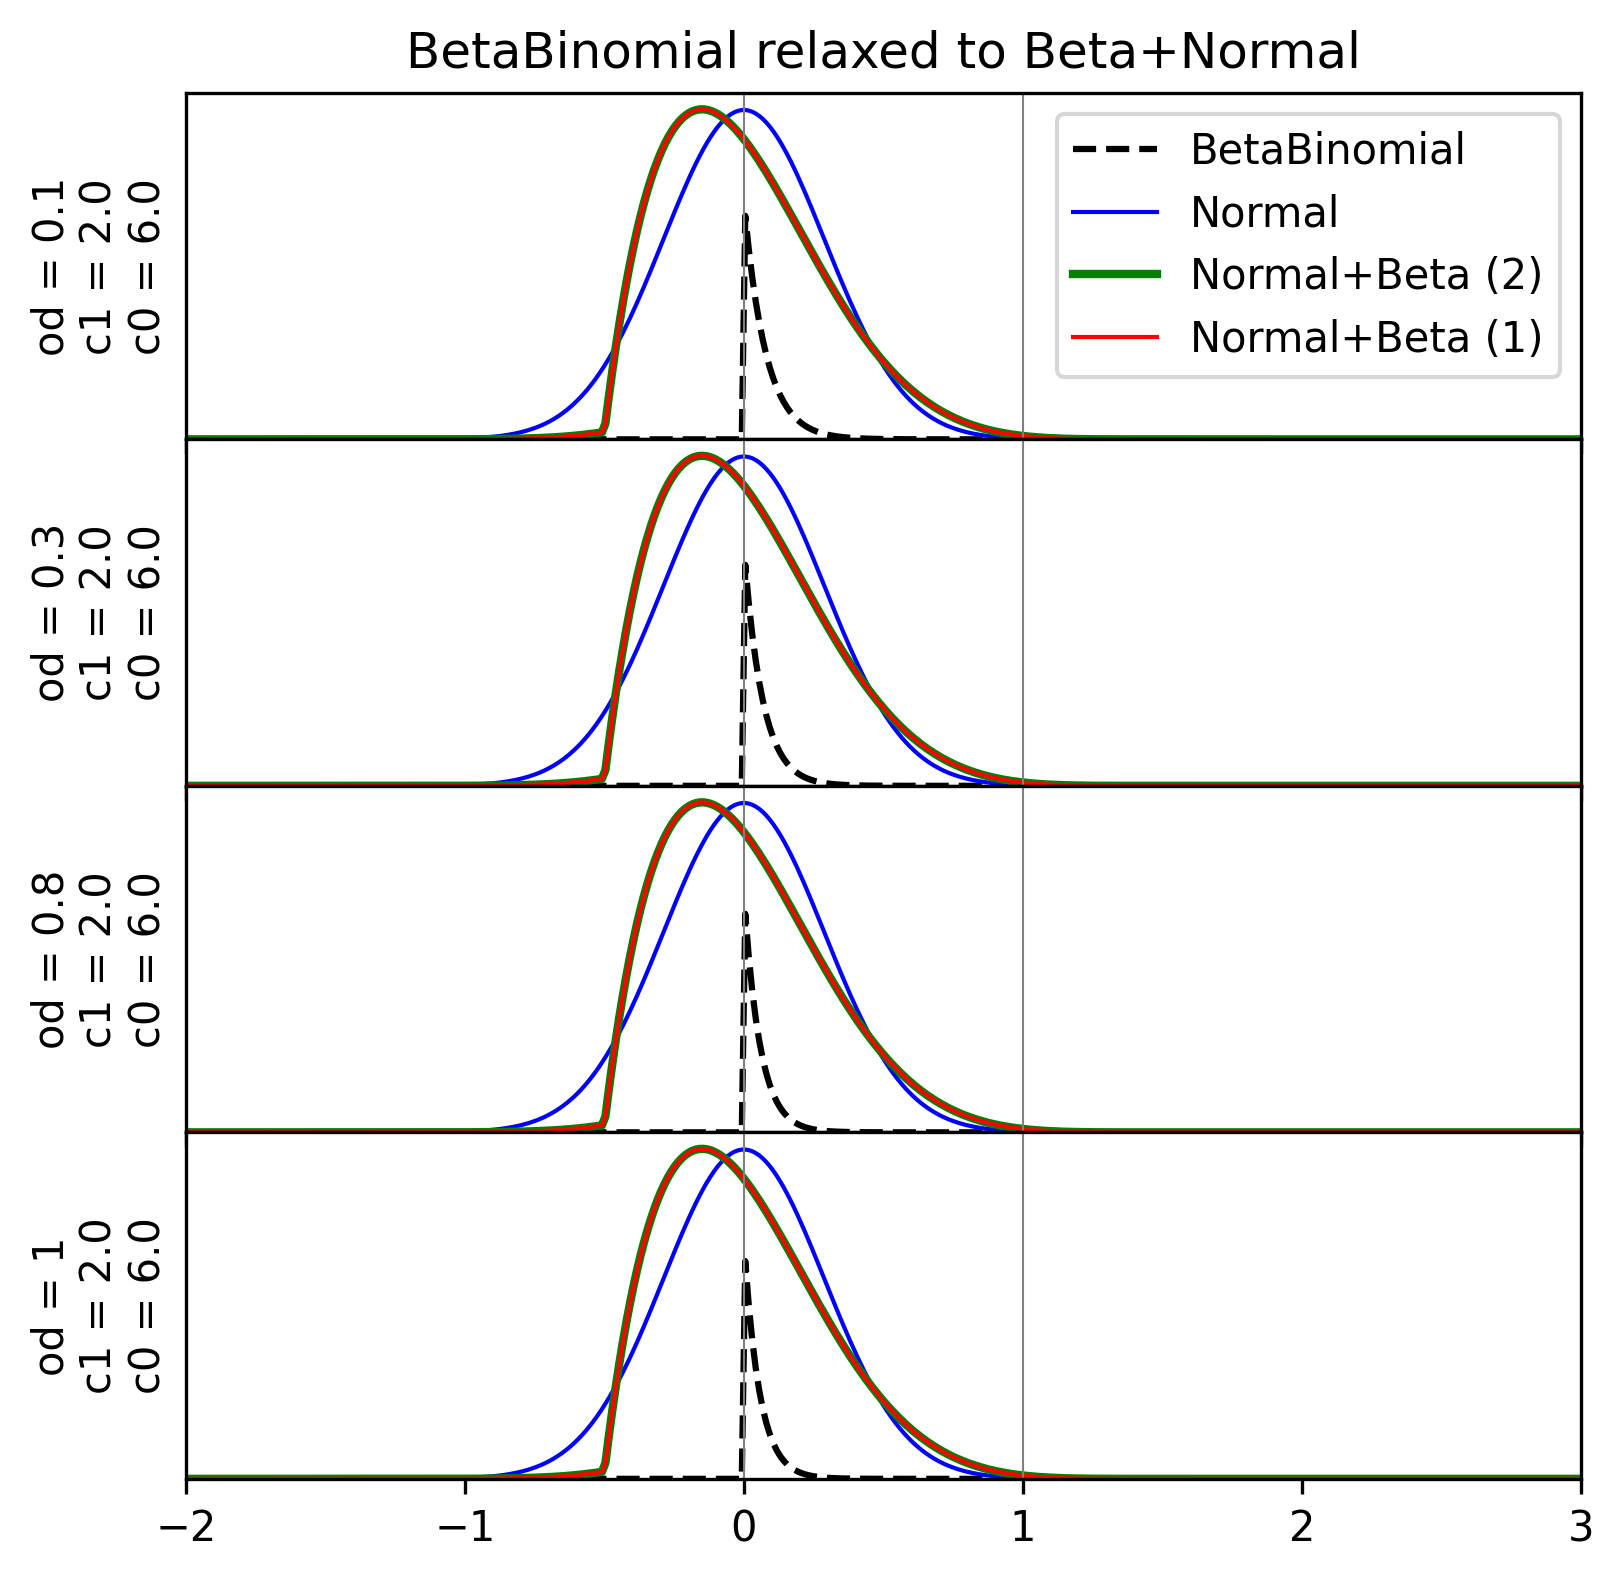

In [13]:
plot_approx(10000., 10., -5., 35.)
plot_approx(10000., 5000., -500., 10500.)
plot_approx(10., 3., -2., 12.)
plot_approx(1., 0., -2., 3.)

Let's test the Pyro implementation, as in the [relaxed-beta-binomial](https://github.com/pyro-ppl/pyro/tree/relaxed-beta-binomial) branch.

In [14]:
def plot_approx(N, N_times_p, lb, ub):
    p = N_times_p / N
    k = torch.linspace(lb, ub, 400)
    ki = torch.arange(lb, ub + 1.0, max(1, int((ub - lb) / 50)))
    ods = [0.1, 0.3, 0.8, 1.0]
    fig, axes = plt.subplots(len(ods), sharex=True, figsize=(6, 6), dpi=300)
    for od, ax in zip(ods, axes):
        d = binomial_dist(N, p, overdispersion=od)
        ax.plot(k, d.log_prob(k).exp(), "k--", label="BetaBinomial")
        
        # Plot the simple normal approximation.
        mean = d.mean
        variance = d.variance + 1/12  # add variance of dequantization
        d1 = dist.Normal(mean, variance.sqrt())
        p1 = d1.log_prob(k).exp()
        ax.plot(k, p1, "b-", lw=1, alpha=0.5, label="Normal")
        
        # Plot the newer Beta+Normal relaxation.
        with set_relaxed_distributions():
            d = binomial_dist(N, p, overdispersion=od)
        ax.plot(ki, d.log_prob(ki).exp(), "go", markeredgewidth=0, markersize=5, alpha=0.8,
                label="Relaxed (no grad)")
        k.requires_grad_(True)
        ax.plot(k.detach(), d.log_prob(k).exp().detach(), "r-", lw=1, label="Relaxed (grad)")
        k.requires_grad_(False)

        ax.set_yticks(())
        ax.axvline(0, color="gray", lw=0.5)
        ax.axvline(N, color="gray", lw=0.5)
        ax.set_ylim(0, None)
        ax.set_ylabel(f"od = {od:0.2g}\nc1 = {c1:0.1f}\nc0 = {c0:0.1f}")
    axes[0].set_title("BetaBinomial relaxed to Beta+Normal")
    axes[0].legend(loc="best")
    axes[-1].set_xlim(lb, ub)
    plt.subplots_adjust(hspace=0)

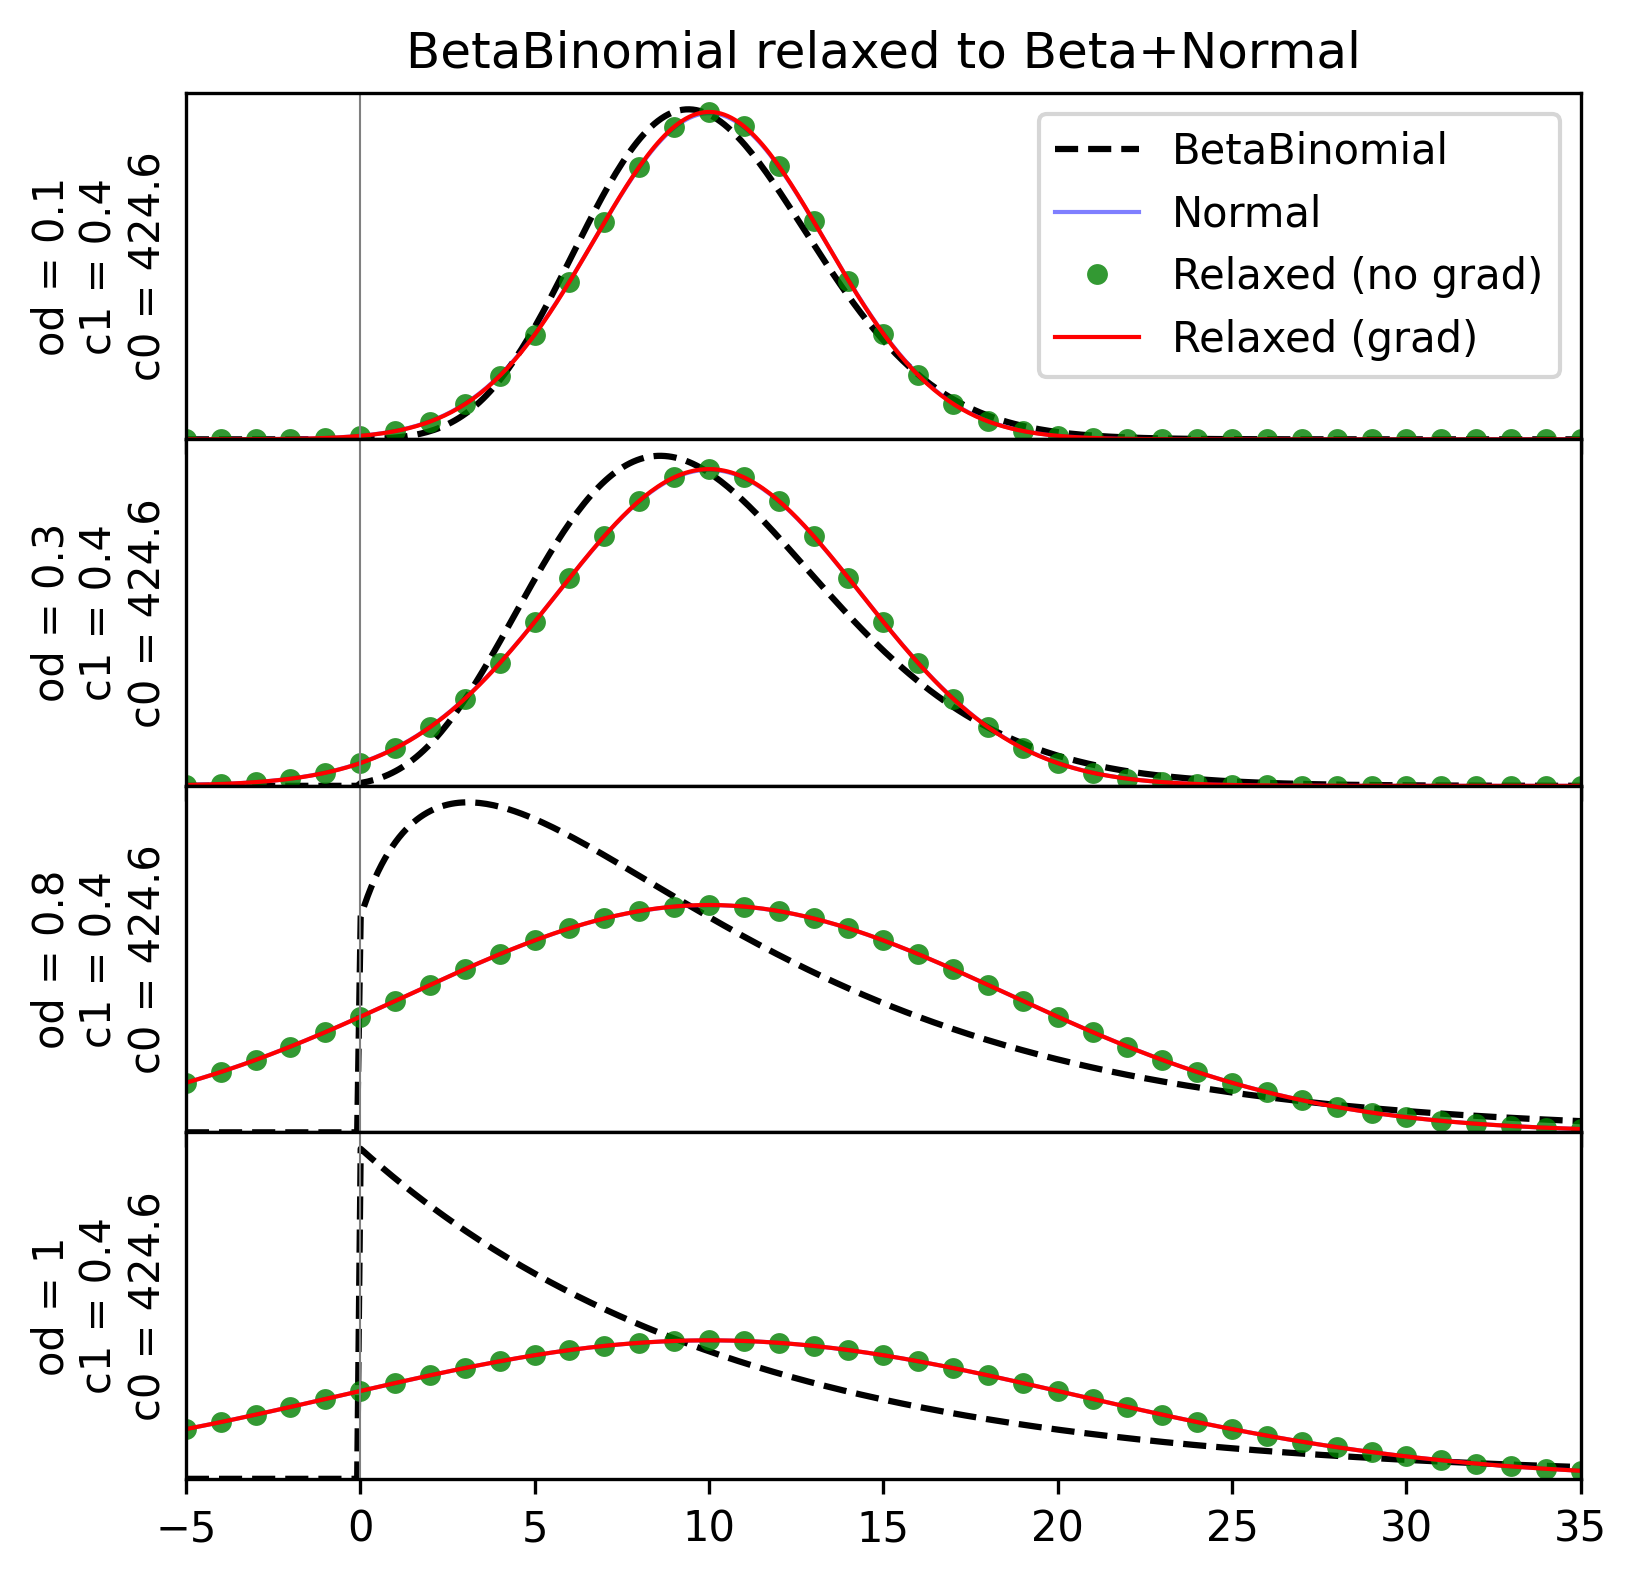

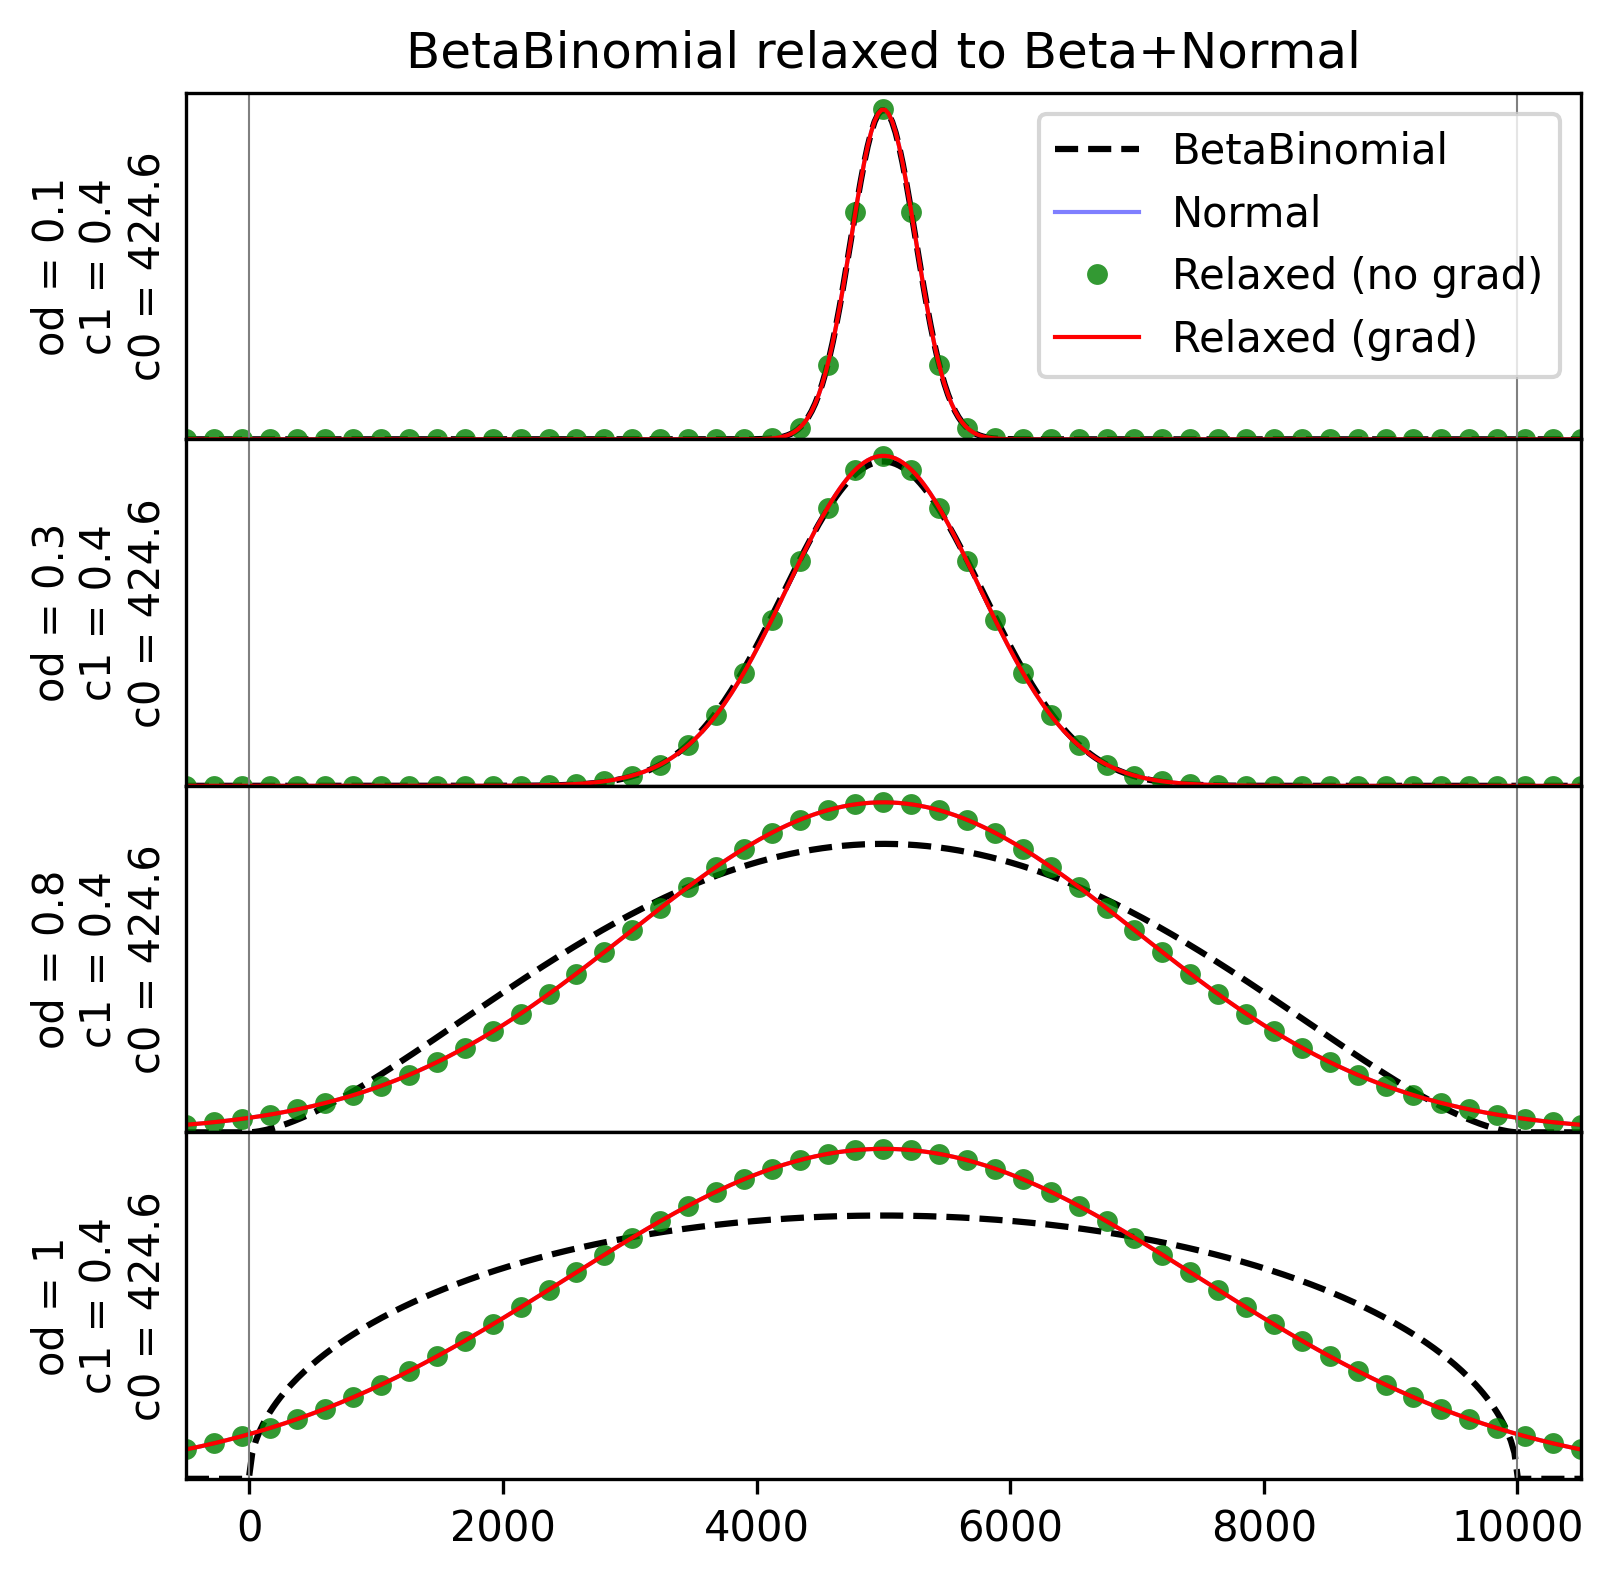

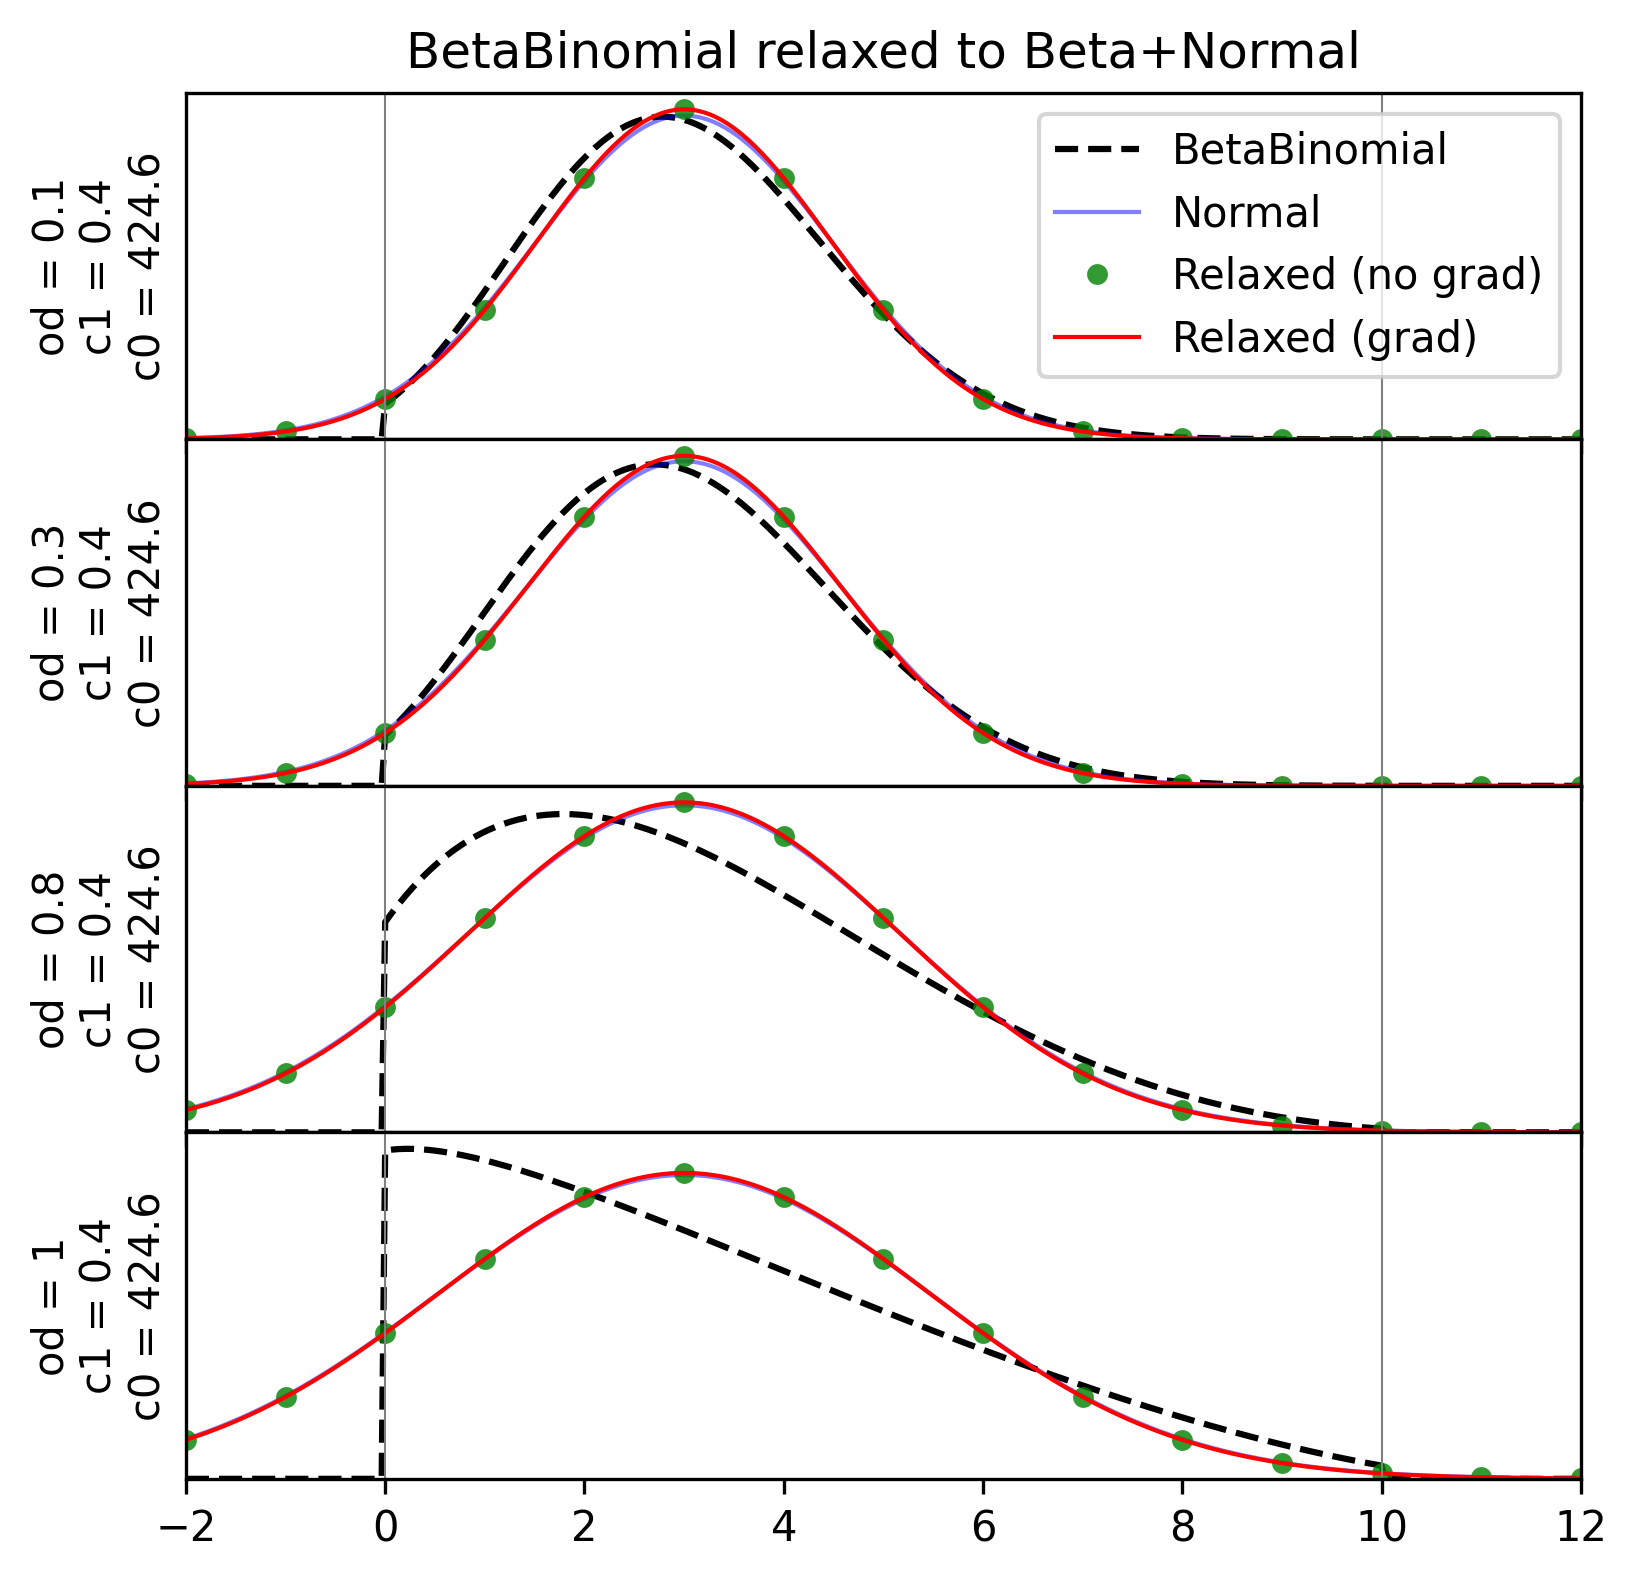

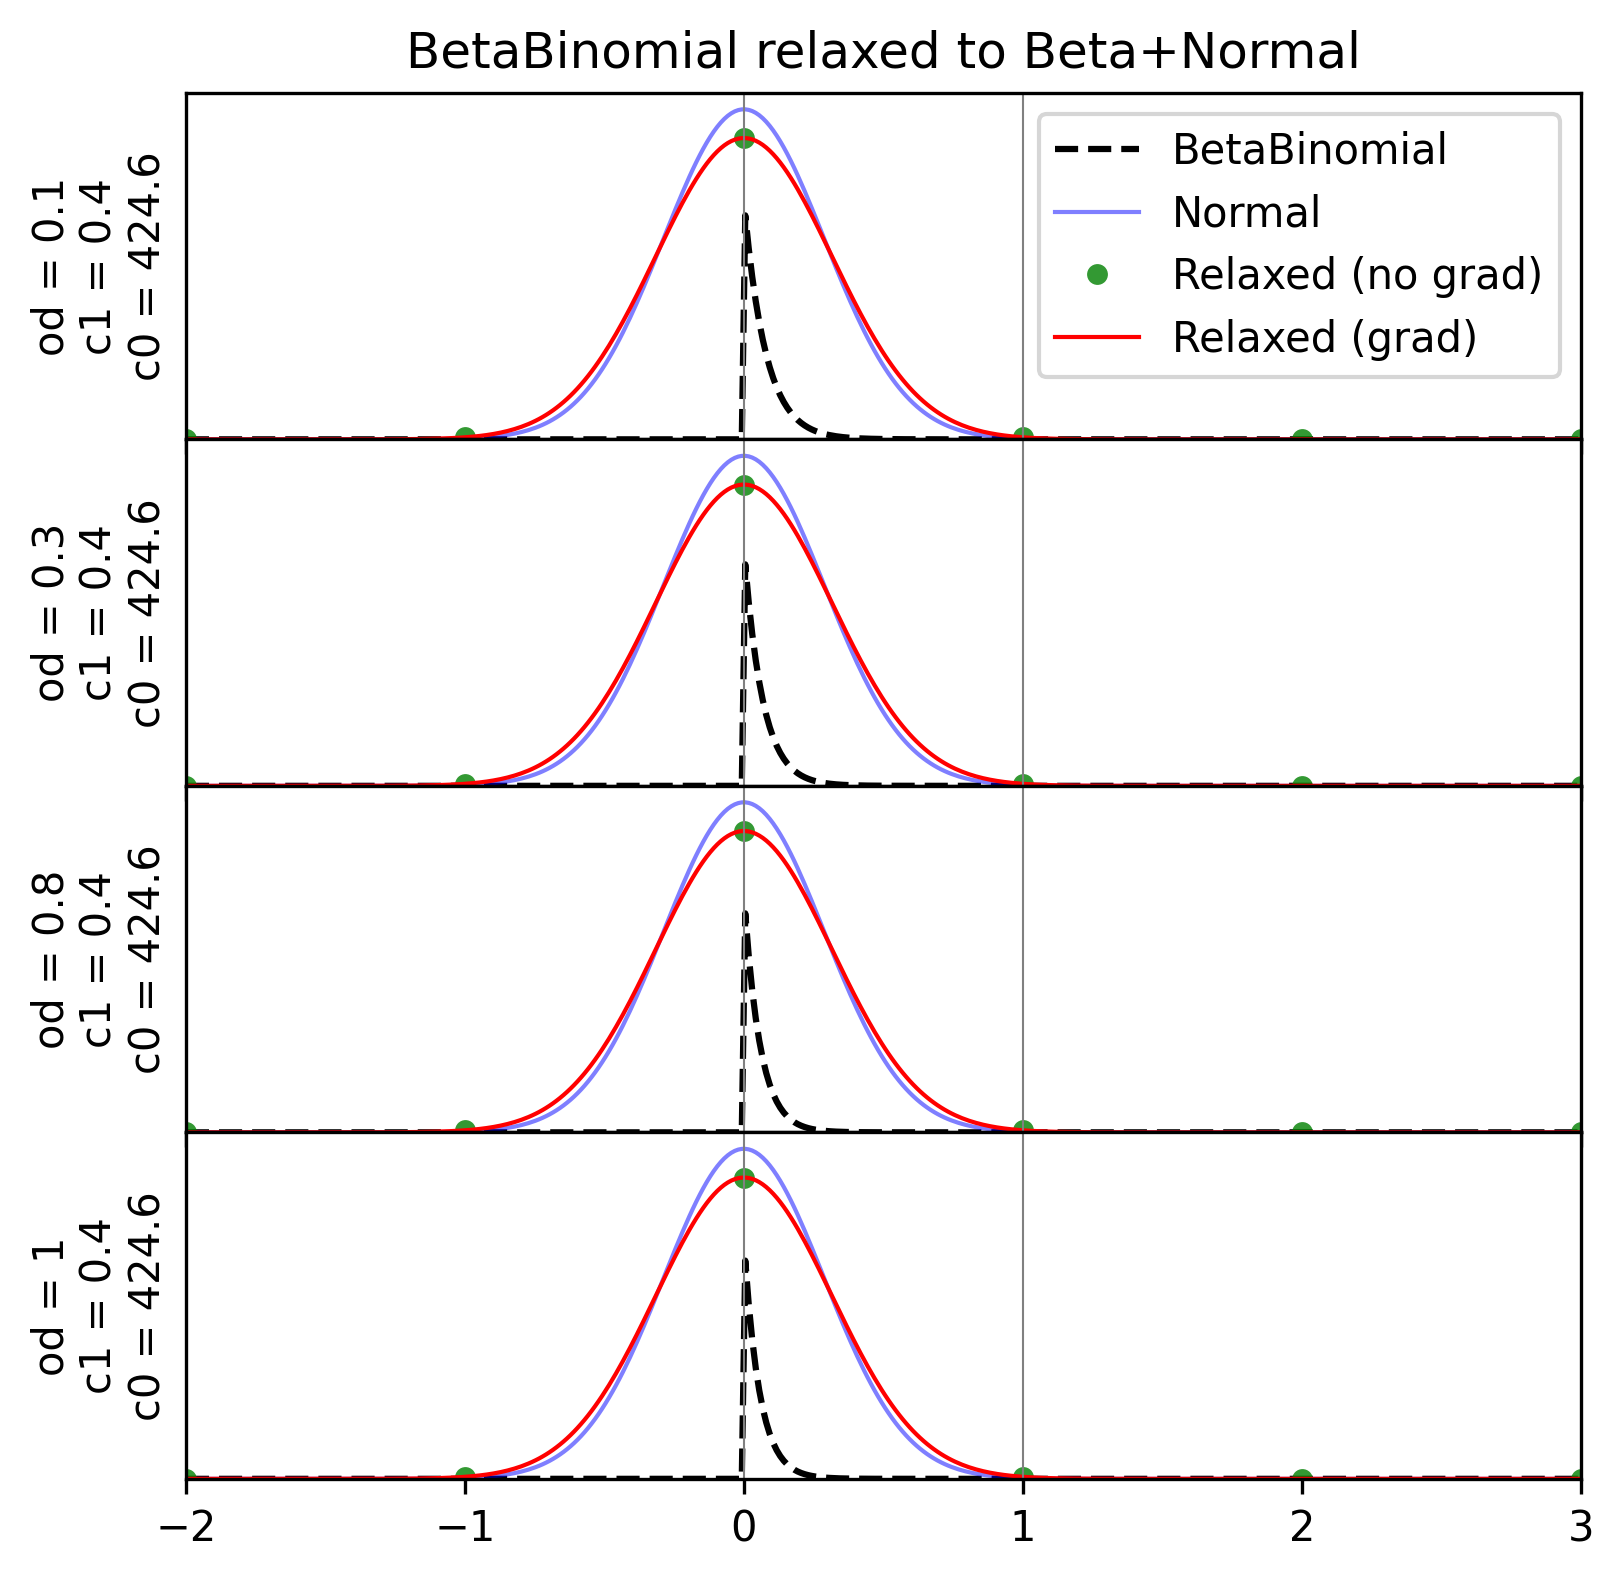

In [15]:
plot_approx(10000., 10., -5., 35.)
plot_approx(10000., 5000., -500., 10500.)
plot_approx(10., 3., -2., 12.)
plot_approx(1., 0., -2., 3.)